In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [2]:
def get_objpoints(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    nx = 9
    ny = 6
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    objpoints = []
    imgpoints = []
    print("Return value :::" + str(ret))
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    return objpoints, imgpoints

In [3]:
def undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    print(img_size)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh_min=0, thresh_max=255):
    """
    Return a color and binary image after applying cv2 sobel thresholds
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype("float")
    s_channel = hls[:,:,2]
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary

In [5]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

In [6]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient direction
    abs_x = np.abs(sobelx)
    abs_y = np.abs(sobely)
    grad_dir = np.arctan2(abs_y, abs_x)
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return binary_output

In [7]:
image = mpimg.imread('signs_vehicles_xygrad.png')
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
image = s_channel

Return value :::True
(1280, 720)


(-0.5, 1279.5, 719.5, -0.5)

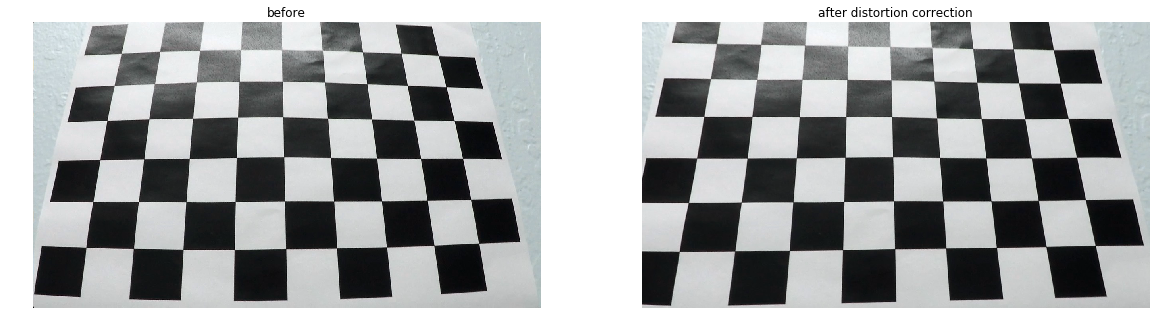

In [8]:
import glob
image = cv2.imread("./camera_cal/calibration3.jpg")
objpoints, imgpoints = get_objpoints(image)
undistorted_image = undistort(image, objpoints, imgpoints)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("before")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.title("after distortion correction");
plt.axis("off")

#write_image(dst, "output_images/camera_calibration.jpg")

  Distortion correction applied to a test image

(1280, 720)


(-0.5, 1279.5, 719.5, -0.5)

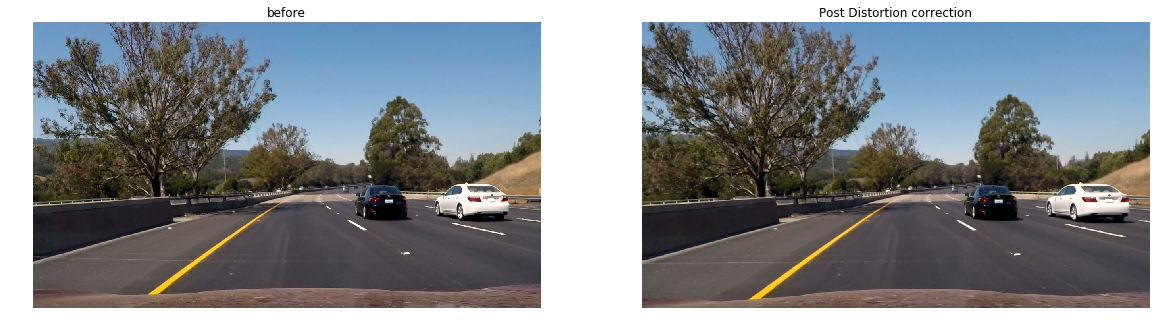

In [9]:
image = cv2.imread("test_images/test6.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_image = undistort(image, objpoints, imgpoints)
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("before")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.title("Post Distortion correction");
plt.axis("off")


# Gradient and lane finding

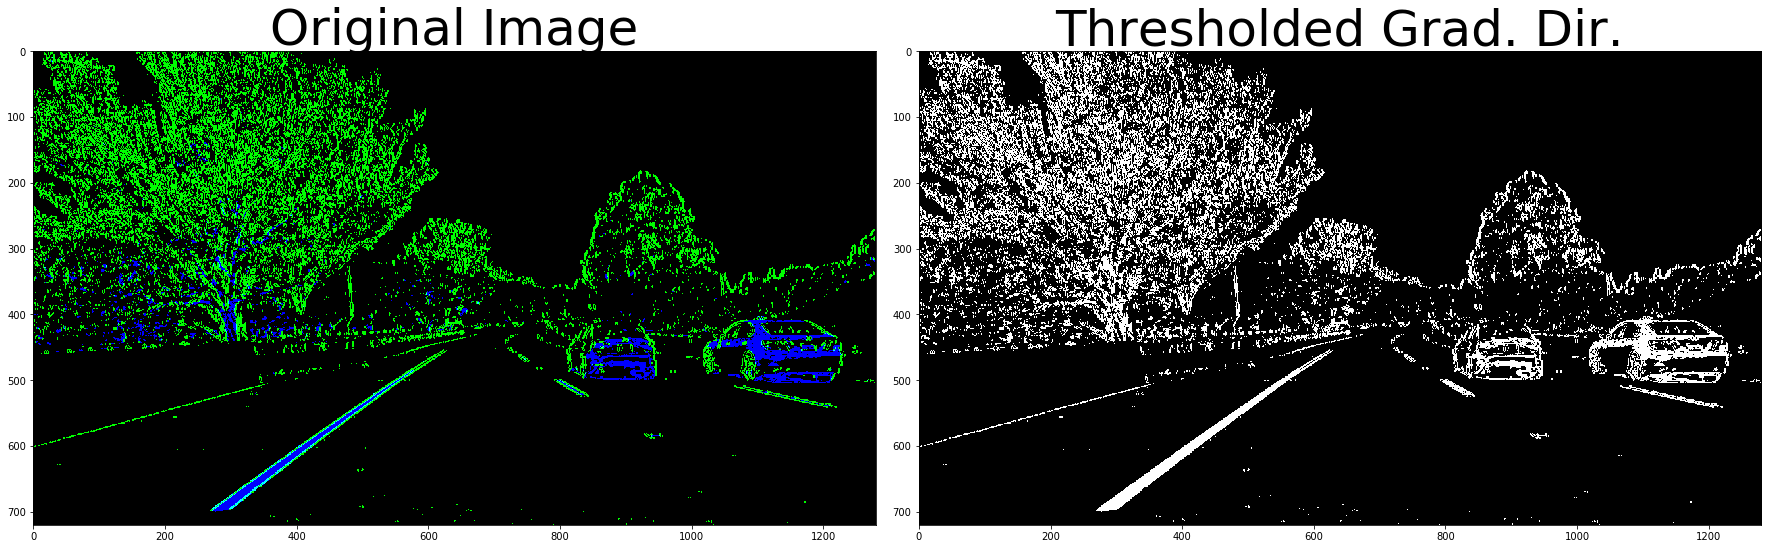

In [10]:
ksize = 15

# Apply each of the thresholding functions
image = undistorted_image
color_binary, combined_binary = abs_sobel_thresh(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [11]:
#Perspective transforms

In [12]:
def get_source_dest_warp_points(new_image):
    center_point = np.uint(image.shape[1]/2)
    y_top = np.uint(image.shape[0]/1.5)
    x_top_left = center_point - .25*np.uint(image.shape[1]/2) + 50
    x_top_right = center_point + .25*np.uint(image.shape[1]/2) - 50
    x_bottom_left = center_point - 1*np.uint(image.shape[1]/2) + 150
    y_bottom_left = np.uint(image.shape[0])
    x_bottom_right = np.uint(image.shape[1]) - 150
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    new_top_left = np.array([corners[0, 0], 0])
    new_top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    img_size = (image.shape[1], image.shape[0])
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    return src, dst




##Get the source and destination points for warping the image

(-0.5, 1279.5, 719.5, -0.5)

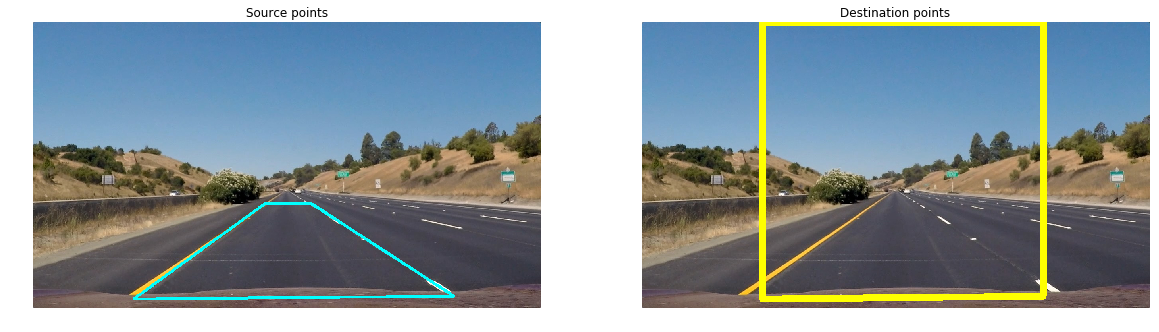

In [13]:
image = cv2.imread("test_images/straight_lines1.jpg")
src, dst = get_source_dest_warp_points(image)

# Plot the chosen source and destination points on the original image
points_image_src = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points_image_dst = points_image_src.copy()


src_pts = src.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_src, [src_pts], True, (0, 255, 255), thickness=5)

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(points_image_src)
plt.title("Source points")
plt.axis("off")
#write_image(points_image_src, "output_images/source_points.jpg")

dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_dst, [dst_pts], True, (255, 255, 0), thickness=15)

plt.subplot(1, 2, 2)
plt.imshow(points_image_dst)
plt.title("Destination points")
plt.axis("off")

In [14]:
##Image warping

In [15]:
def warp2_image(img, src, dst, image_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

(1280, 720)
(1280, 720)


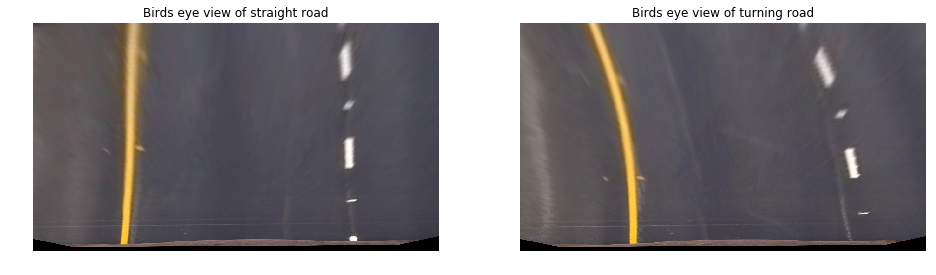

In [16]:
# Read in the same test image as used above and plot
image = cv2.imread("test_images/straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = undistort(image, objpoints, imgpoints)
src, dst = get_source_dest_warp_points(image)
warped, _, _ = warp2_image(image, src, dst, (image.shape[1], image.shape[0]))

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(warped)
plt.title("Birds eye view of straight road");
plt.axis("off")

# Read in an image with straight lane lines to check the warped lines are parallel
image2 = cv2.imread("test_images/test2.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

image2 = undistort(image2, objpoints, imgpoints)
warped2, _, _ = warp2_image(image2, src, dst, (image2.shape[1], image2.shape[0]))

plt.subplot(1, 2, 2)
plt.imshow(warped2)
plt.title("Birds eye view of turning road")
plt.axis("off");

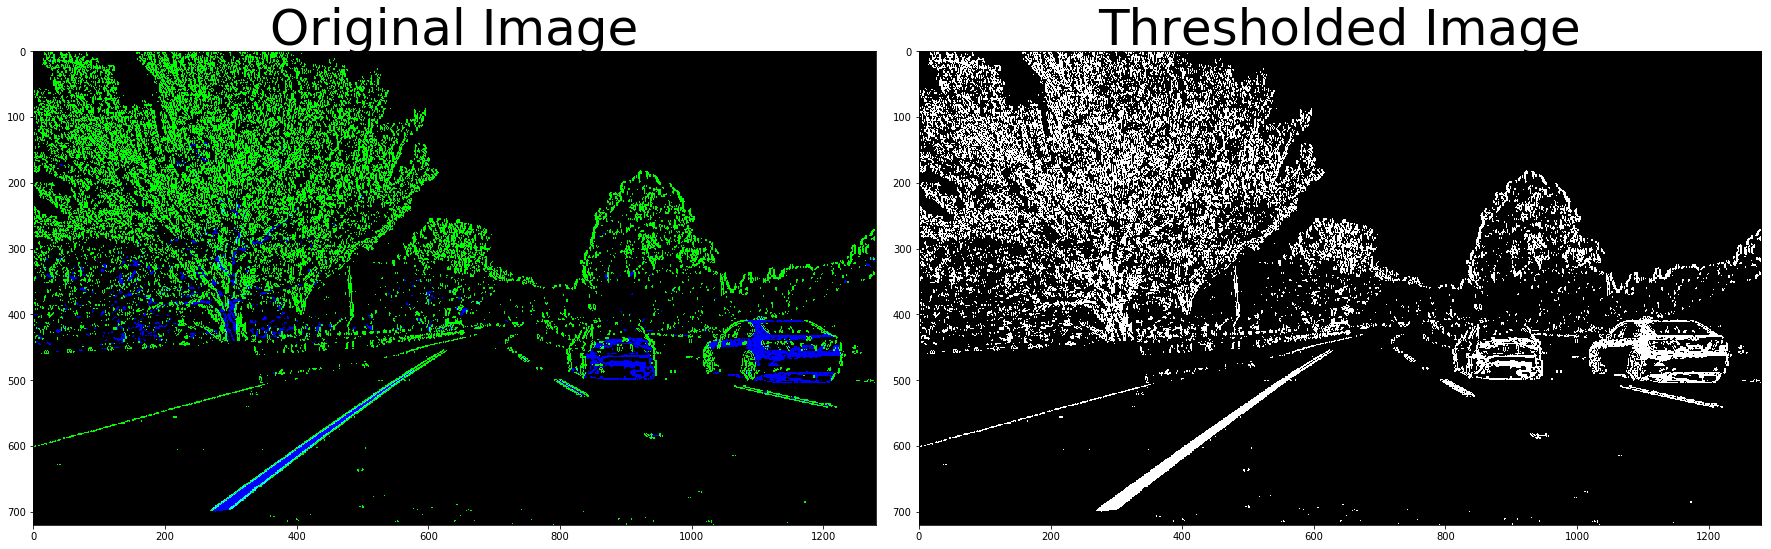

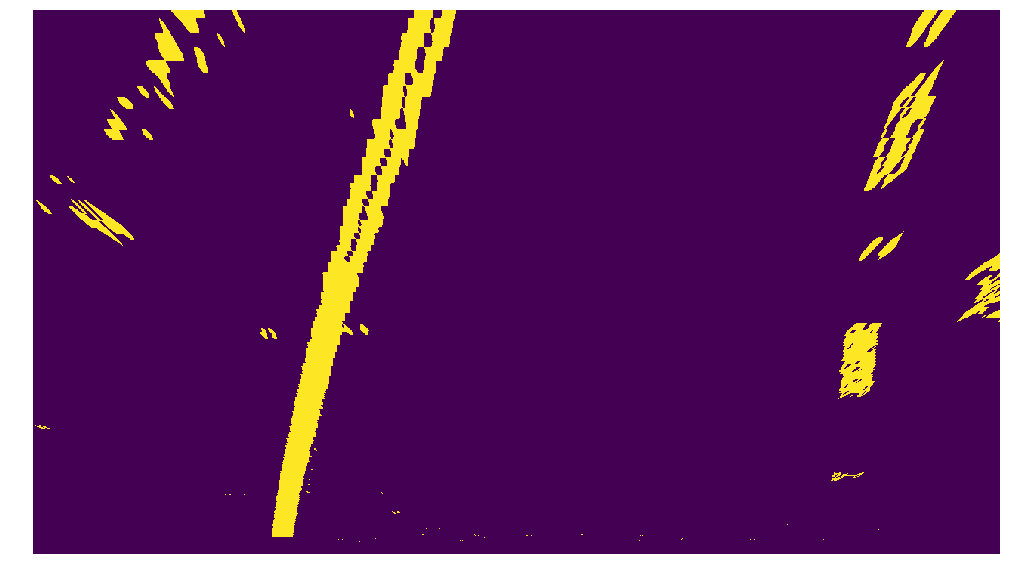

In [17]:
image = undistorted_image
color_binary, combined_binary = abs_sobel_thresh(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(color_binary)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
binary_warped, _, Minv = warp2_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
plt.figure(figsize=(20,10))
plt.imshow(binary_warped)
plt.axis("off")

# save as file
binary = 255 * binary_warped.astype("uint8")

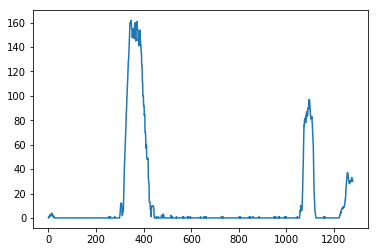

In [18]:
b_w = int(binary_warped.shape[0]/2)
histogram = np.sum(binary_warped[b_w:,:], axis=0)
plt.plot(histogram);

In [19]:
def get_radius_of_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    y_eval = np.max(ploty)
    
    ymeters_per_pix = 30/720 # meters per pixel in y dimension
    xmeters_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cords = np.polyfit(lefty * ymeters_per_pix, leftx * xmeters_per_pix, 2)
    right_fit_cords = np.polyfit(righty *ymeters_per_pix, rightx * xmeters_per_pix, 2)
    
    # new radii of curvature
    left_curve_radius = ((1 + (2 * left_fit_cords[0] * y_eval * ymeters_per_pix + left_fit_cords[1])**2)**1.5) / np.absolute(2 * left_fit_cords[0])
    right_curve_radius = ((1 + (2 * right_fit_cords[0] * y_eval * ymeters_per_pix + right_fit_cords[1])**2)**1.5) / np.absolute(2 * right_fit_cords[0])
    
    print("Radius of curvature left ::::= {:.2f} m".format(left_curve_radius))
    print("Radius of curvature right ::::= {:.2f} m".format(right_curve_radius))
    
    # Calculate Lane Deviation from center of lane
    scene_height = image_size[0] * ymeters_per_pix
    scene_width = image_size[1] * xmeters_per_pix
    
    left_intercept = left_fit_cords[0] * scene_height ** 2 + left_fit_cords[1] * scene_height + left_fit_cords[2]
    right_intercept = right_fit_cords[0] * scene_height ** 2 + right_fit_cords[1] * scene_height + right_fit_cords[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    
    return left_curve_radius, right_curve_radius, lane_deviation

In [20]:
def find_lane_lines(binary_warped, debug=False):
    nwindows = 9
    
    if debug == True:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    b_w = int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[b_w:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    print("Window Height ::::" + str(window_height))
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    print("Current Left Positions ::::" + str(leftx_current))
    print("Currernt Right positions :::::" + str(rightx_current))
    
    margin = 100
    minpix = 50
   
    #Empty lists for left and right indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0] )
    left_fit_new_x = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fit_new_x = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    l, r, d = get_radius_of_curvature(leftx, lefty, rightx, righty, ploty, binary_warped.shape)
    
    if debug == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fit_new_x, right_fit_new_x, ploty, left_fit, right_fit, l, r, d, out_img
    else:
        return left_fit_new_x, right_fit_new_x, ploty, left_fit, right_fit, l, r, d

Window Height ::::80
Current Left Positions ::::347
Currernt Right positions :::::1095
Radius of curvature left ::::= 1046.24 m
Radius of curvature right ::::= 802.05 m


(0.0, 1280.0, 720.0, 0.0)

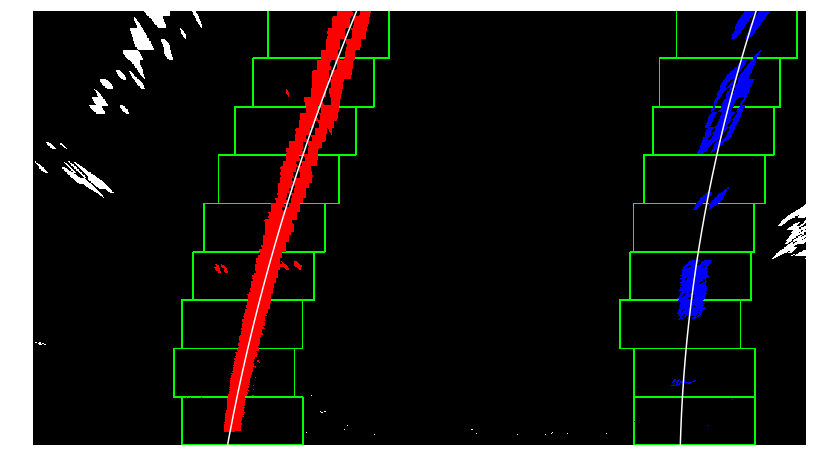

In [21]:
left_fit_x, right_fit_x, plot_y, left_fit, right_fit, l, r, d, out_img = find_lane_lines(binary_warped, debug=True)

plt.figure(figsize=(14,8))
plt.imshow(out_img)
plt.plot(left_fit_x, plot_y, color='white')
plt.plot(right_fit_x, plot_y, color='white')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off")

In [27]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.fit_x = fit_x
        self.radius = radius
        self.deviation = deviation
        self.ploty = ploty
        
    def get_fitted_lines():
        return self.fit_x, self.radius, self.deviation, self.ploty
    
    def add_fitted_lines(self, fit_coefs):
        if self.detected == False:
            self.recent_xfitted = fit_coefs
            self.detected = True
            
        
        

In [28]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):

    warp_zero_copy = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp_copy = np.dstack((warp_zero_copy, warp_zero_copy, warp_zero_copy))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(pts)
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp_copy, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image
    newwarp = cv2.warpPerspective(color_warp_copy, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_SIMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_SIMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)        
    return result


In [41]:

def process_image(image, detected = False):
    """
    Execute the image processing pipeline on the provided image.
    """
    global left_curve, right_curve, left_lane_inds, right_lane_inds
    undistorted = undistort(image, objpoints, imgpoints)
    _, combined_binary = abs_sobel_thresh(undistorted)
    src, dst = get_source_dest_warp_points(image)
    binary_warped, _, Minv = warp2_image(combined_binary, src, dst, (image.shape[1], image.shape[0]))
    if detected == False:
        left_fitx, right_fitx, ploty, _, _, left_radius, right_radius, deviation = find_lane_lines(binary_warped)
        left_line = Line(left_fitx, left_radius, deviation, ploty)
        right_line = Line(right_fitx, right_radius, deviation, ploty)
        detected = True
    else:
        left_fitx, left_radius, ploty = left_line.get_params()
        right_fitx, right_radius, ploty = right_line.get_params()
    lane_lines_image = draw_lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, deviation)
    return lane_lines_image

(1280, 720)
Window Height ::::80
Current Left Positions ::::347
Currernt Right positions :::::1095
Radius of curvature left ::::= 1046.24 m
Radius of curvature right ::::= 802.05 m


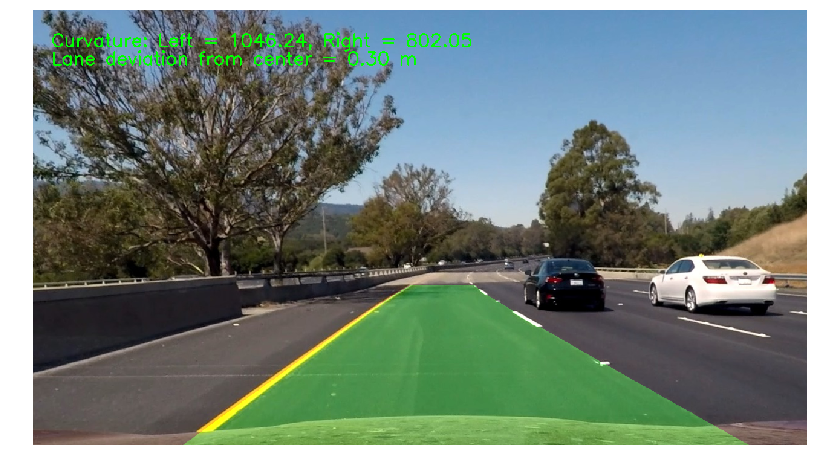

In [42]:
img = cv2.imread("test_images/test6.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = process_image(img, False)

plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");

In [ ]:
from moviepy.editor import VideoFileClip
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

(1280, 720)
Window Height ::::80
Current Left Positions ::::343
Currernt Right positions :::::1068
Radius of curvature left ::::= 513.99 m
Radius of curvature right ::::= 402.72 m
[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(1280, 720)


  0%|          | 1/1261 [00:00<11:07,  1.89it/s]

Window Height ::::80
Current Left Positions ::::343
Currernt Right positions :::::1068
Radius of curvature left ::::= 513.99 m
Radius of curvature right ::::= 402.72 m
(1280, 720)


  0%|          | 2/1261 [00:01<11:45,  1.78it/s]

Window Height ::::80
Current Left Positions ::::352
Currernt Right positions :::::1069
Radius of curvature left ::::= 522.01 m
Radius of curvature right ::::= 414.03 m
(1280, 720)


  0%|          | 3/1261 [00:01<12:31,  1.67it/s]

Window Height ::::80
Current Left Positions ::::343
Currernt Right positions :::::1072
Radius of curvature left ::::= 468.41 m
Radius of curvature right ::::= 571.51 m
(1280, 720)


  0%|          | 4/1261 [00:02<12:26,  1.68it/s]

Window Height ::::80
Current Left Positions ::::345
Currernt Right positions :::::1075
Radius of curvature left ::::= 480.26 m
Radius of curvature right ::::= 693.51 m
(1280, 720)


  0%|          | 5/1261 [00:02<11:59,  1.75it/s]

Window Height ::::80
Current Left Positions ::::351
Currernt Right positions :::::1077
Radius of curvature left ::::= 524.34 m
Radius of curvature right ::::= 874.42 m
(1280, 720)


  0%|          | 6/1261 [00:03<12:24,  1.69it/s]

Window Height ::::80
Current Left Positions ::::351
Currernt Right positions :::::1024
Radius of curvature left ::::= 479.29 m
Radius of curvature right ::::= 920.30 m
(1280, 720)


  1%|          | 7/1261 [00:04<12:20,  1.69it/s]

Window Height ::::80
Current Left Positions ::::349
Currernt Right positions :::::1022
Radius of curvature left ::::= 497.52 m
Radius of curvature right ::::= 849.72 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::350
Currernt Right positions :::::1028
Radius of curvature left ::::= 501.74 m
Radius of curvature right ::::= 776.17 m


  1%|          | 8/1261 [00:05<14:06,  1.48it/s]

(1280, 720)


  1%|          | 9/1261 [00:05<14:28,  1.44it/s]

Window Height ::::80
Current Left Positions ::::349
Currernt Right positions :::::1041
Radius of curvature left ::::= 522.44 m
Radius of curvature right ::::= 883.73 m
(1280, 720)


  1%|          | 10/1261 [00:06<13:31,  1.54it/s]

Window Height ::::80
Current Left Positions ::::349
Currernt Right positions :::::1045
Radius of curvature left ::::= 551.75 m
Radius of curvature right ::::= 2422.33 m
(1280, 720)


  1%|          | 11/1261 [00:06<13:26,  1.55it/s]

Window Height ::::80
Current Left Positions ::::345
Currernt Right positions :::::1043
Radius of curvature left ::::= 566.48 m
Radius of curvature right ::::= 1343.16 m
(1280, 720)


  1%|          | 12/1261 [00:07<13:26,  1.55it/s]

Window Height ::::80
Current Left Positions ::::346
Currernt Right positions :::::1059
Radius of curvature left ::::= 604.43 m
Radius of curvature right ::::= 2457.68 m
(1280, 720)


  1%|          | 13/1261 [00:08<13:16,  1.57it/s]

Window Height ::::80
Current Left Positions ::::347
Currernt Right positions :::::1062
Radius of curvature left ::::= 645.54 m
Radius of curvature right ::::= 508.70 m
(1280, 720)


  1%|          | 14/1261 [00:08<12:50,  1.62it/s]

Window Height ::::80
Current Left Positions ::::347
Currernt Right positions :::::1066
Radius of curvature left ::::= 782.36 m
Radius of curvature right ::::= 487.93 m
(1280, 720)


  1%|          | 15/1261 [00:09<12:31,  1.66it/s]

Window Height ::::80
Current Left Positions ::::349
Currernt Right positions :::::1067
Radius of curvature left ::::= 702.83 m
Radius of curvature right ::::= 619.13 m
(1280, 720)


  1%|▏         | 16/1261 [00:09<12:11,  1.70it/s]

Window Height ::::80
Current Left Positions ::::348
Currernt Right positions :::::1067
Radius of curvature left ::::= 739.89 m
Radius of curvature right ::::= 878.11 m
(1280, 720)


  1%|▏         | 17/1261 [00:10<11:51,  1.75it/s]

Window Height ::::80
Current Left Positions ::::347
Currernt Right positions :::::1071
Radius of curvature left ::::= 674.17 m
Radius of curvature right ::::= 949.78 m
(1280, 720)


  1%|▏         | 18/1261 [00:10<11:29,  1.80it/s]

Window Height ::::80
Current Left Positions ::::350
Currernt Right positions :::::1068
Radius of curvature left ::::= 713.76 m
Radius of curvature right ::::= 791.60 m
(1280, 720)


  2%|▏         | 19/1261 [00:11<11:17,  1.83it/s]

Window Height ::::80
Current Left Positions ::::346
Currernt Right positions :::::1005
Radius of curvature left ::::= 770.11 m
Radius of curvature right ::::= 733.82 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::344
Currernt Right positions :::::1014
Radius of curvature left ::::= 849.53 m
Radius of curvature right ::::= 668.84 m


  2%|▏         | 20/1261 [00:12<11:46,  1.76it/s]

(1280, 720)


  2%|▏         | 21/1261 [00:13<14:17,  1.45it/s]

Window Height ::::80
Current Left Positions ::::344
Currernt Right positions :::::1021
Radius of curvature left ::::= 815.66 m
Radius of curvature right ::::= 600.00 m
(1280, 720)


  2%|▏         | 22/1261 [00:13<13:32,  1.52it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1030
Radius of curvature left ::::= 820.18 m
Radius of curvature right ::::= 643.93 m
(1280, 720)


  2%|▏         | 23/1261 [00:14<12:57,  1.59it/s]

Window Height ::::80
Current Left Positions ::::326
Currernt Right positions :::::1038
Radius of curvature left ::::= 786.06 m
Radius of curvature right ::::= 628.83 m
(1280, 720)


  2%|▏         | 24/1261 [00:14<12:33,  1.64it/s]

Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::1041
Radius of curvature left ::::= 741.59 m
Radius of curvature right ::::= 1043.24 m
(1280, 720)


  2%|▏         | 25/1261 [00:15<14:03,  1.46it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1044
Radius of curvature left ::::= 672.21 m
Radius of curvature right ::::= 518.57 m
(1280, 720)


  2%|▏         | 26/1261 [00:16<15:28,  1.33it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1053
Radius of curvature left ::::= 721.84 m
Radius of curvature right ::::= 549.94 m
(1280, 720)


  2%|▏         | 27/1261 [00:17<14:41,  1.40it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1058
Radius of curvature left ::::= 633.59 m
Radius of curvature right ::::= 408.05 m
(1280, 720)


  2%|▏         | 28/1261 [00:17<13:31,  1.52it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1064
Radius of curvature left ::::= 642.09 m
Radius of curvature right ::::= 466.75 m
(1280, 720)


  2%|▏         | 29/1261 [00:18<12:52,  1.60it/s]

Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::1068
Radius of curvature left ::::= 657.16 m
Radius of curvature right ::::= 482.32 m
(1280, 720)


  2%|▏         | 30/1261 [00:18<13:24,  1.53it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1067
Radius of curvature left ::::= 634.43 m
Radius of curvature right ::::= 645.46 m
(1280, 720)


  2%|▏         | 31/1261 [00:20<17:49,  1.15it/s]

Window Height ::::80
Current Left Positions ::::329
Currernt Right positions :::::1071
Radius of curvature left ::::= 531.69 m
Radius of curvature right ::::= 787.54 m
(1280, 720)


  3%|▎         | 32/1261 [00:21<18:10,  1.13it/s]

Window Height ::::80
Current Left Positions ::::336
Currernt Right positions :::::1016
Radius of curvature left ::::= 516.91 m
Radius of curvature right ::::= 711.32 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::1023
Radius of curvature left ::::= 495.93 m
Radius of curvature right ::::= 683.01 m


  3%|▎         | 33/1261 [00:22<21:11,  1.04s/it]

(1280, 720)


  3%|▎         | 34/1261 [00:23<21:34,  1.05s/it]

Window Height ::::80
Current Left Positions ::::329
Currernt Right positions :::::1029
Radius of curvature left ::::= 462.30 m
Radius of curvature right ::::= 501.54 m
(1280, 720)


  3%|▎         | 35/1261 [00:24<20:11,  1.01it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1031
Radius of curvature left ::::= 444.96 m
Radius of curvature right ::::= 626.74 m
(1280, 720)


  3%|▎         | 36/1261 [00:25<19:04,  1.07it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1037
Radius of curvature left ::::= 425.73 m
Radius of curvature right ::::= 574.96 m
(1280, 720)


  3%|▎         | 37/1261 [00:26<17:10,  1.19it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1040
Radius of curvature left ::::= 405.18 m
Radius of curvature right ::::= 356.32 m
(1280, 720)


  3%|▎         | 38/1261 [00:26<16:32,  1.23it/s]

Window Height ::::80
Current Left Positions ::::340
Currernt Right positions :::::1047
Radius of curvature left ::::= 371.57 m
Radius of curvature right ::::= 365.22 m
(1280, 720)


  3%|▎         | 39/1261 [00:27<14:58,  1.36it/s]

Window Height ::::80
Current Left Positions ::::345
Currernt Right positions :::::1048
Radius of curvature left ::::= 363.49 m
Radius of curvature right ::::= 453.47 m
(1280, 720)


  3%|▎         | 40/1261 [00:27<13:29,  1.51it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1053
Radius of curvature left ::::= 371.29 m
Radius of curvature right ::::= 462.53 m
(1280, 720)


  3%|▎         | 41/1261 [00:28<12:41,  1.60it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1059
Radius of curvature left ::::= 375.98 m
Radius of curvature right ::::= 546.50 m
(1280, 720)


  3%|▎         | 42/1261 [00:28<11:55,  1.70it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1063
Radius of curvature left ::::= 395.86 m
Radius of curvature right ::::= 573.07 m
(1280, 720)


  3%|▎         | 43/1261 [00:29<11:43,  1.73it/s]

Window Height ::::80
Current Left Positions ::::339
Currernt Right positions :::::1071
Radius of curvature left ::::= 408.18 m
Radius of curvature right ::::= 606.06 m
(1280, 720)


  3%|▎         | 44/1261 [00:29<11:22,  1.78it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1001
Radius of curvature left ::::= 431.42 m
Radius of curvature right ::::= 644.18 m
(1280, 720)


  4%|▎         | 45/1261 [00:30<11:21,  1.78it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1010
Radius of curvature left ::::= 435.87 m
Radius of curvature right ::::= 677.06 m
(1280, 720)


  4%|▎         | 46/1261 [00:31<11:11,  1.81it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1014
Radius of curvature left ::::= 453.84 m
Radius of curvature right ::::= 541.72 m
(1280, 720)


  4%|▎         | 47/1261 [00:31<11:12,  1.81it/s]

Window Height ::::80
Current Left Positions ::::337
Currernt Right positions :::::1034
Radius of curvature left ::::= 446.64 m
Radius of curvature right ::::= 481.39 m
(1280, 720)


  4%|▍         | 48/1261 [00:32<11:01,  1.83it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1036
Radius of curvature left ::::= 451.36 m
Radius of curvature right ::::= 606.36 m
(1280, 720)


  4%|▍         | 49/1261 [00:32<10:59,  1.84it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1043
Radius of curvature left ::::= 520.95 m
Radius of curvature right ::::= 715.11 m
(1280, 720)


  4%|▍         | 50/1261 [00:33<10:47,  1.87it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1048
Radius of curvature left ::::= 505.91 m
Radius of curvature right ::::= 437.84 m
(1280, 720)


  4%|▍         | 51/1261 [00:33<10:50,  1.86it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1053
Radius of curvature left ::::= 548.85 m
Radius of curvature right ::::= 386.02 m
(1280, 720)


  4%|▍         | 52/1261 [00:34<10:58,  1.84it/s]

Window Height ::::80
Current Left Positions ::::336
Currernt Right positions :::::1055
Radius of curvature left ::::= 592.72 m
Radius of curvature right ::::= 417.51 m
(1280, 720)


  4%|▍         | 53/1261 [00:34<10:45,  1.87it/s]

Window Height ::::80
Current Left Positions ::::336
Currernt Right positions :::::1058
Radius of curvature left ::::= 585.93 m
Radius of curvature right ::::= 487.89 m
(1280, 720)


  4%|▍         | 54/1261 [00:35<10:47,  1.87it/s]

Window Height ::::80
Current Left Positions ::::336
Currernt Right positions :::::1063
Radius of curvature left ::::= 664.49 m
Radius of curvature right ::::= 553.73 m
(1280, 720)


  4%|▍         | 55/1261 [00:35<10:52,  1.85it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1065
Radius of curvature left ::::= 812.74 m
Radius of curvature right ::::= 659.61 m
(1280, 720)


  4%|▍         | 56/1261 [00:36<14:15,  1.41it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1065
Radius of curvature left ::::= 800.24 m
Radius of curvature right ::::= 710.89 m
(1280, 720)


  5%|▍         | 57/1261 [00:37<13:36,  1.48it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1005
Radius of curvature left ::::= 824.02 m
Radius of curvature right ::::= 690.87 m
(1280, 720)


  5%|▍         | 58/1261 [00:38<12:41,  1.58it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1015
Radius of curvature left ::::= 806.82 m
Radius of curvature right ::::= 631.03 m
(1280, 720)


  5%|▍         | 59/1261 [00:38<12:00,  1.67it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1016
Radius of curvature left ::::= 695.66 m
Radius of curvature right ::::= 839.62 m
(1280, 720)


  5%|▍         | 60/1261 [00:39<11:35,  1.73it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1017
Radius of curvature left ::::= 659.47 m
Radius of curvature right ::::= 490.63 m
(1280, 720)


  5%|▍         | 61/1261 [00:39<11:08,  1.79it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1023
Radius of curvature left ::::= 640.40 m
Radius of curvature right ::::= 418.90 m
(1280, 720)


  5%|▍         | 62/1261 [00:40<10:55,  1.83it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1026
Radius of curvature left ::::= 557.53 m
Radius of curvature right ::::= 499.29 m
(1280, 720)


  5%|▍         | 63/1261 [00:40<10:37,  1.88it/s]

Window Height ::::80
Current Left Positions ::::332
Currernt Right positions :::::1027
Radius of curvature left ::::= 553.60 m
Radius of curvature right ::::= 575.07 m
(1280, 720)


  5%|▌         | 64/1261 [00:41<10:37,  1.88it/s]

Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::1041
Radius of curvature left ::::= 550.09 m
Radius of curvature right ::::= 741.37 m
(1280, 720)


  5%|▌         | 65/1261 [00:41<10:28,  1.90it/s]

Window Height ::::80
Current Left Positions ::::329
Currernt Right positions :::::1048
Radius of curvature left ::::= 579.94 m
Radius of curvature right ::::= 805.94 m
(1280, 720)


  5%|▌         | 66/1261 [00:42<10:19,  1.93it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1042
Radius of curvature left ::::= 560.59 m
Radius of curvature right ::::= 850.05 m
(1280, 720)


  5%|▌         | 67/1261 [00:42<10:23,  1.92it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1050
Radius of curvature left ::::= 570.28 m
Radius of curvature right ::::= 775.59 m
(1280, 720)


  5%|▌         | 68/1261 [00:43<10:25,  1.91it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1048
Radius of curvature left ::::= 630.64 m
Radius of curvature right ::::= 741.93 m
(1280, 720)


  5%|▌         | 69/1261 [00:43<10:25,  1.91it/s]

Window Height ::::80
Current Left Positions ::::325
Currernt Right positions :::::972
Radius of curvature left ::::= 642.02 m
Radius of curvature right ::::= 665.46 m
(1280, 720)


  6%|▌         | 70/1261 [00:44<10:22,  1.91it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::981
Radius of curvature left ::::= 710.73 m
Radius of curvature right ::::= 698.90 m
(1280, 720)


  6%|▌         | 71/1261 [00:44<10:26,  1.90it/s]

Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::987
Radius of curvature left ::::= 731.06 m
Radius of curvature right ::::= 647.91 m
(1280, 720)


  6%|▌         | 72/1261 [00:45<10:31,  1.88it/s]

Window Height ::::80
Current Left Positions ::::320
Currernt Right positions :::::992
Radius of curvature left ::::= 751.09 m
Radius of curvature right ::::= 513.55 m
(1280, 720)


  6%|▌         | 73/1261 [00:45<10:36,  1.87it/s]

Window Height ::::80
Current Left Positions ::::318
Currernt Right positions :::::1000
Radius of curvature left ::::= 824.52 m
Radius of curvature right ::::= 393.88 m
(1280, 720)


  6%|▌         | 74/1261 [00:46<10:54,  1.81it/s]

Window Height ::::80
Current Left Positions ::::317
Currernt Right positions :::::1005
Radius of curvature left ::::= 837.10 m
Radius of curvature right ::::= 329.49 m
(1280, 720)


  6%|▌         | 75/1261 [00:47<12:30,  1.58it/s]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1010
Radius of curvature left ::::= 888.14 m
Radius of curvature right ::::= 359.68 m
(1280, 720)


  6%|▌         | 76/1261 [00:47<12:14,  1.61it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1016
Radius of curvature left ::::= 1048.21 m
Radius of curvature right ::::= 392.53 m
(1280, 720)


  6%|▌         | 77/1261 [00:48<11:47,  1.67it/s]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1025
Radius of curvature left ::::= 1183.54 m
Radius of curvature right ::::= 430.49 m
(1280, 720)


  6%|▌         | 78/1261 [00:49<11:30,  1.71it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1034
Radius of curvature left ::::= 1272.32 m
Radius of curvature right ::::= 450.33 m
(1280, 720)


  6%|▋         | 79/1261 [00:49<11:09,  1.76it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1039
Radius of curvature left ::::= 1267.96 m
Radius of curvature right ::::= 506.09 m
(1280, 720)


  6%|▋         | 80/1261 [00:50<11:06,  1.77it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1046
Radius of curvature left ::::= 1222.84 m
Radius of curvature right ::::= 592.36 m
(1280, 720)


  6%|▋         | 81/1261 [00:50<10:50,  1.81it/s]

Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1045
Radius of curvature left ::::= 1253.83 m
Radius of curvature right ::::= 724.96 m
(1280, 720)


  7%|▋         | 82/1261 [00:51<10:40,  1.84it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::987
Radius of curvature left ::::= 1131.75 m
Radius of curvature right ::::= 748.29 m
(1280, 720)


  7%|▋         | 83/1261 [00:51<10:34,  1.86it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::1000
Radius of curvature left ::::= 1062.95 m
Radius of curvature right ::::= 732.11 m
(1280, 720)


  7%|▋         | 84/1261 [00:52<10:35,  1.85it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1002
Radius of curvature left ::::= 1122.13 m
Radius of curvature right ::::= 1980.68 m
(1280, 720)


  7%|▋         | 85/1261 [00:52<10:26,  1.88it/s]

Window Height ::::80
Current Left Positions ::::299
Currernt Right positions :::::1008
Radius of curvature left ::::= 982.36 m
Radius of curvature right ::::= 730.10 m
(1280, 720)


  7%|▋         | 86/1261 [00:53<10:29,  1.87it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1013
Radius of curvature left ::::= 867.31 m
Radius of curvature right ::::= 917.09 m
(1280, 720)


  7%|▋         | 87/1261 [00:53<10:24,  1.88it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1013
Radius of curvature left ::::= 696.86 m
Radius of curvature right ::::= 525.79 m
(1280, 720)


  7%|▋         | 88/1261 [00:54<10:41,  1.83it/s]

Window Height ::::80
Current Left Positions ::::301
Currernt Right positions :::::1014
Radius of curvature left ::::= 581.81 m
Radius of curvature right ::::= 440.50 m
(1280, 720)


  7%|▋         | 89/1261 [00:54<10:35,  1.84it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1036
Radius of curvature left ::::= 531.14 m
Radius of curvature right ::::= 523.05 m
(1280, 720)


  7%|▋         | 90/1261 [00:55<10:37,  1.84it/s]

Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1028
Radius of curvature left ::::= 507.94 m
Radius of curvature right ::::= 705.68 m
(1280, 720)


  7%|▋         | 91/1261 [00:56<10:34,  1.85it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1037
Radius of curvature left ::::= 525.27 m
Radius of curvature right ::::= 692.23 m
(1280, 720)


  7%|▋         | 92/1261 [00:56<10:32,  1.85it/s]

Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1042
Radius of curvature left ::::= 529.65 m
Radius of curvature right ::::= 733.94 m
(1280, 720)


  7%|▋         | 93/1261 [00:57<11:24,  1.71it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1036
Radius of curvature left ::::= 519.58 m
Radius of curvature right ::::= 691.48 m
(1280, 720)


  7%|▋         | 94/1261 [00:58<12:31,  1.55it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::973
Radius of curvature left ::::= 519.04 m
Radius of curvature right ::::= 617.93 m
(1280, 720)


  8%|▊         | 95/1261 [00:58<11:53,  1.63it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::985
Radius of curvature left ::::= 520.40 m
Radius of curvature right ::::= 650.95 m
(1280, 720)


  8%|▊         | 96/1261 [00:59<11:38,  1.67it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::986
Radius of curvature left ::::= 514.26 m
Radius of curvature right ::::= 707.11 m
(1280, 720)


  8%|▊         | 97/1261 [00:59<11:14,  1.73it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::993
Radius of curvature left ::::= 505.20 m
Radius of curvature right ::::= 715.73 m
(1280, 720)


  8%|▊         | 98/1261 [01:00<10:58,  1.77it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1007
Radius of curvature left ::::= 549.87 m
Radius of curvature right ::::= 821.07 m
(1280, 720)


  8%|▊         | 99/1261 [01:00<10:40,  1.81it/s]

Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1007
Radius of curvature left ::::= 545.71 m
Radius of curvature right ::::= 377.72 m
(1280, 720)


  8%|▊         | 100/1261 [01:01<10:50,  1.79it/s]

Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1007
Radius of curvature left ::::= 548.52 m
Radius of curvature right ::::= 377.78 m
(1280, 720)


  8%|▊         | 101/1261 [01:01<10:44,  1.80it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1014
Radius of curvature left ::::= 536.23 m
Radius of curvature right ::::= 383.85 m
(1280, 720)


  8%|▊         | 102/1261 [01:02<11:06,  1.74it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1017
Radius of curvature left ::::= 520.37 m
Radius of curvature right ::::= 457.48 m
(1280, 720)


  8%|▊         | 103/1261 [01:03<11:01,  1.75it/s]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1023
Radius of curvature left ::::= 526.91 m
Radius of curvature right ::::= 512.18 m
(1280, 720)


  8%|▊         | 104/1261 [01:03<11:09,  1.73it/s]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1028
Radius of curvature left ::::= 532.15 m
Radius of curvature right ::::= 552.32 m
(1280, 720)


  8%|▊         | 105/1261 [01:04<10:57,  1.76it/s]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1035
Radius of curvature left ::::= 562.87 m
Radius of curvature right ::::= 603.56 m
(1280, 720)


  8%|▊         | 106/1261 [01:04<10:41,  1.80it/s]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1039
Radius of curvature left ::::= 589.99 m
Radius of curvature right ::::= 690.60 m
(1280, 720)


  8%|▊         | 107/1261 [01:05<10:35,  1.82it/s]

Window Height ::::80
Current Left Positions ::::318
Currernt Right positions :::::1023
Radius of curvature left ::::= 599.11 m
Radius of curvature right ::::= 723.75 m
(1280, 720)


  9%|▊         | 108/1261 [01:05<10:26,  1.84it/s]

Window Height ::::80
Current Left Positions ::::318
Currernt Right positions :::::1000
Radius of curvature left ::::= 545.47 m
Radius of curvature right ::::= 619.52 m
(1280, 720)


  9%|▊         | 109/1261 [01:06<10:35,  1.81it/s]

Window Height ::::80
Current Left Positions ::::320
Currernt Right positions :::::1006
Radius of curvature left ::::= 533.72 m
Radius of curvature right ::::= 451.16 m
(1280, 720)


  9%|▊         | 110/1261 [01:06<10:41,  1.79it/s]

Window Height ::::80
Current Left Positions ::::320
Currernt Right positions :::::1031
Radius of curvature left ::::= 534.23 m
Radius of curvature right ::::= 478.29 m
(1280, 720)


  9%|▉         | 111/1261 [01:07<11:25,  1.68it/s]

Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::1024
Radius of curvature left ::::= 515.02 m
Radius of curvature right ::::= 631.64 m
(1280, 720)


  9%|▉         | 112/1261 [01:08<12:50,  1.49it/s]

Window Height ::::80
Current Left Positions ::::320
Currernt Right positions :::::1027
Radius of curvature left ::::= 546.08 m
Radius of curvature right ::::= 648.52 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::1048
Radius of curvature left ::::= 500.24 m
Radius of curvature right ::::= 363.70 m


  9%|▉         | 113/1261 [01:09<13:34,  1.41it/s]

(1280, 720)


  9%|▉         | 114/1261 [01:10<15:03,  1.27it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1036
Radius of curvature left ::::= 527.42 m
Radius of curvature right ::::= 343.45 m
(1280, 720)


  9%|▉         | 115/1261 [01:11<15:46,  1.21it/s]

Window Height ::::80
Current Left Positions ::::326
Currernt Right positions :::::1044
Radius of curvature left ::::= 513.16 m
Radius of curvature right ::::= 410.85 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1045
Radius of curvature left ::::= 490.55 m
Radius of curvature right ::::= 462.89 m


  9%|▉         | 116/1261 [01:11<15:51,  1.20it/s]

(1280, 720)


  9%|▉         | 117/1261 [01:13<17:06,  1.11it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1050
Radius of curvature left ::::= 483.52 m
Radius of curvature right ::::= 497.89 m
(1280, 720)


  9%|▉         | 118/1261 [01:14<17:35,  1.08it/s]

Window Height ::::80
Current Left Positions ::::325
Currernt Right positions :::::1051
Radius of curvature left ::::= 505.89 m
Radius of curvature right ::::= 518.38 m
(1280, 720)


  9%|▉         | 119/1261 [01:14<16:26,  1.16it/s]

Window Height ::::80
Current Left Positions ::::326
Currernt Right positions :::::1058
Radius of curvature left ::::= 497.82 m
Radius of curvature right ::::= 512.09 m
(1280, 720)


 10%|▉         | 120/1261 [01:15<14:44,  1.29it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::995
Radius of curvature left ::::= 459.72 m
Radius of curvature right ::::= 436.48 m
(1280, 720)


 10%|▉         | 121/1261 [01:15<13:21,  1.42it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1012
Radius of curvature left ::::= 470.09 m
Radius of curvature right ::::= 493.95 m
(1280, 720)


 10%|▉         | 122/1261 [01:16<12:37,  1.50it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1008
Radius of curvature left ::::= 460.95 m
Radius of curvature right ::::= 563.25 m
(1280, 720)


 10%|▉         | 123/1261 [01:17<13:17,  1.43it/s]

Window Height ::::80
Current Left Positions ::::332
Currernt Right positions :::::1023
Radius of curvature left ::::= 449.06 m
Radius of curvature right ::::= 339.82 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1028
Radius of curvature left ::::= 452.79 m
Radius of curvature right ::::= 315.53 m


 10%|▉         | 124/1261 [01:18<14:57,  1.27it/s]

(1280, 720)


 10%|▉         | 125/1261 [01:19<15:04,  1.26it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1025
Radius of curvature left ::::= 439.38 m
Radius of curvature right ::::= 365.09 m
(1280, 720)


 10%|▉         | 126/1261 [01:19<13:50,  1.37it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1033
Radius of curvature left ::::= 454.00 m
Radius of curvature right ::::= 383.15 m
(1280, 720)


 10%|█         | 127/1261 [01:20<12:41,  1.49it/s]

Window Height ::::80
Current Left Positions ::::336
Currernt Right positions :::::1057
Radius of curvature left ::::= 438.25 m
Radius of curvature right ::::= 421.99 m
(1280, 720)


 10%|█         | 128/1261 [01:20<12:00,  1.57it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1062
Radius of curvature left ::::= 466.10 m
Radius of curvature right ::::= 445.22 m
(1280, 720)


 10%|█         | 129/1261 [01:21<11:17,  1.67it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1063
Radius of curvature left ::::= 447.62 m
Radius of curvature right ::::= 552.59 m
(1280, 720)


 10%|█         | 130/1261 [01:21<10:56,  1.72it/s]

Window Height ::::80
Current Left Positions ::::340
Currernt Right positions :::::1056
Radius of curvature left ::::= 460.67 m
Radius of curvature right ::::= 531.98 m
(1280, 720)


 10%|█         | 131/1261 [01:22<11:12,  1.68it/s]

Window Height ::::80
Current Left Positions ::::342
Currernt Right positions :::::1058
Radius of curvature left ::::= 485.13 m
Radius of curvature right ::::= 475.93 m
(1280, 720)


 10%|█         | 132/1261 [01:23<12:21,  1.52it/s]

Window Height ::::80
Current Left Positions ::::343
Currernt Right positions :::::993
Radius of curvature left ::::= 481.62 m
Radius of curvature right ::::= 516.32 m
(1280, 720)


 11%|█         | 133/1261 [01:23<12:25,  1.51it/s]

Window Height ::::80
Current Left Positions ::::342
Currernt Right positions :::::1011
Radius of curvature left ::::= 495.59 m
Radius of curvature right ::::= 527.22 m
(1280, 720)


 11%|█         | 134/1261 [01:24<11:45,  1.60it/s]

Window Height ::::80
Current Left Positions ::::343
Currernt Right positions :::::1010
Radius of curvature left ::::= 498.89 m
Radius of curvature right ::::= 593.16 m
(1280, 720)


 11%|█         | 135/1261 [01:24<11:22,  1.65it/s]

Window Height ::::80
Current Left Positions ::::347
Currernt Right positions :::::1016
Radius of curvature left ::::= 491.61 m
Radius of curvature right ::::= 457.56 m
(1280, 720)


 11%|█         | 136/1261 [01:25<11:07,  1.68it/s]

Window Height ::::80
Current Left Positions ::::348
Currernt Right positions :::::1037
Radius of curvature left ::::= 547.11 m
Radius of curvature right ::::= 411.59 m
(1280, 720)


 11%|█         | 137/1261 [01:26<10:46,  1.74it/s]

Window Height ::::80
Current Left Positions ::::347
Currernt Right positions :::::1047
Radius of curvature left ::::= 555.37 m
Radius of curvature right ::::= 446.03 m
(1280, 720)


 11%|█         | 138/1261 [01:26<10:33,  1.77it/s]

Window Height ::::80
Current Left Positions ::::344
Currernt Right positions :::::1049
Radius of curvature left ::::= 572.59 m
Radius of curvature right ::::= 439.42 m
(1280, 720)


 11%|█         | 139/1261 [01:27<10:20,  1.81it/s]

Window Height ::::80
Current Left Positions ::::345
Currernt Right positions :::::1054
Radius of curvature left ::::= 660.71 m
Radius of curvature right ::::= 515.51 m
(1280, 720)


 11%|█         | 140/1261 [01:27<10:19,  1.81it/s]

Window Height ::::80
Current Left Positions ::::340
Currernt Right positions :::::1055
Radius of curvature left ::::= 685.00 m
Radius of curvature right ::::= 552.60 m
(1280, 720)


 11%|█         | 141/1261 [01:28<10:20,  1.80it/s]

Window Height ::::80
Current Left Positions ::::340
Currernt Right positions :::::1067
Radius of curvature left ::::= 626.42 m
Radius of curvature right ::::= 665.27 m
(1280, 720)


 11%|█▏        | 142/1261 [01:29<11:53,  1.57it/s]

Window Height ::::80
Current Left Positions ::::339
Currernt Right positions :::::1071
Radius of curvature left ::::= 720.30 m
Radius of curvature right ::::= 752.92 m
(1280, 720)


 11%|█▏        | 143/1261 [01:29<11:37,  1.60it/s]

Window Height ::::80
Current Left Positions ::::343
Currernt Right positions :::::1064
Radius of curvature left ::::= 680.51 m
Radius of curvature right ::::= 997.27 m
(1280, 720)


 11%|█▏        | 144/1261 [01:30<11:11,  1.66it/s]

Window Height ::::80
Current Left Positions ::::342
Currernt Right positions :::::1067
Radius of curvature left ::::= 664.83 m
Radius of curvature right ::::= 827.85 m
(1280, 720)


 11%|█▏        | 145/1261 [01:30<10:56,  1.70it/s]

Window Height ::::80
Current Left Positions ::::341
Currernt Right positions :::::1005
Radius of curvature left ::::= 677.56 m
Radius of curvature right ::::= 745.51 m
(1280, 720)


 12%|█▏        | 146/1261 [01:31<10:35,  1.75it/s]

Window Height ::::80
Current Left Positions ::::341
Currernt Right positions :::::1006
Radius of curvature left ::::= 668.92 m
Radius of curvature right ::::= 684.75 m
(1280, 720)


 12%|█▏        | 147/1261 [01:31<10:30,  1.77it/s]

Window Height ::::80
Current Left Positions ::::340
Currernt Right positions :::::1016
Radius of curvature left ::::= 688.07 m
Radius of curvature right ::::= 608.65 m
(1280, 720)


 12%|█▏        | 148/1261 [01:32<10:57,  1.69it/s]

Window Height ::::80
Current Left Positions ::::345
Currernt Right positions :::::1017
Radius of curvature left ::::= 683.45 m
Radius of curvature right ::::= 362.75 m
(1280, 720)


 12%|█▏        | 149/1261 [01:33<10:35,  1.75it/s]

Window Height ::::80
Current Left Positions ::::345
Currernt Right positions :::::1028
Radius of curvature left ::::= 659.87 m
Radius of curvature right ::::= 370.22 m
(1280, 720)


 12%|█▏        | 150/1261 [01:33<10:27,  1.77it/s]

Window Height ::::80
Current Left Positions ::::343
Currernt Right positions :::::1040
Radius of curvature left ::::= 658.82 m
Radius of curvature right ::::= 405.15 m
(1280, 720)


 12%|█▏        | 151/1261 [01:34<10:22,  1.78it/s]

Window Height ::::80
Current Left Positions ::::339
Currernt Right positions :::::1040
Radius of curvature left ::::= 683.17 m
Radius of curvature right ::::= 399.16 m
(1280, 720)


 12%|█▏        | 152/1261 [01:34<10:32,  1.75it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1051
Radius of curvature left ::::= 737.74 m
Radius of curvature right ::::= 474.79 m
(1280, 720)


 12%|█▏        | 153/1261 [01:35<10:36,  1.74it/s]

Window Height ::::80
Current Left Positions ::::339
Currernt Right positions :::::1052
Radius of curvature left ::::= 695.25 m
Radius of curvature right ::::= 584.88 m
(1280, 720)


 12%|█▏        | 154/1261 [01:35<10:36,  1.74it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1060
Radius of curvature left ::::= 705.79 m
Radius of curvature right ::::= 674.38 m
(1280, 720)


 12%|█▏        | 155/1261 [01:36<10:32,  1.75it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1064
Radius of curvature left ::::= 712.23 m
Radius of curvature right ::::= 730.49 m
(1280, 720)


 12%|█▏        | 156/1261 [01:37<11:02,  1.67it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1064
Radius of curvature left ::::= 709.27 m
Radius of curvature right ::::= 776.27 m
(1280, 720)


 12%|█▏        | 157/1261 [01:37<10:56,  1.68it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1029
Radius of curvature left ::::= 664.20 m
Radius of curvature right ::::= 716.89 m
(1280, 720)


 13%|█▎        | 158/1261 [01:38<10:33,  1.74it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1006
Radius of curvature left ::::= 598.49 m
Radius of curvature right ::::= 658.87 m
(1280, 720)


 13%|█▎        | 159/1261 [01:38<10:39,  1.72it/s]

Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::1018
Radius of curvature left ::::= 621.67 m
Radius of curvature right ::::= 916.34 m
(1280, 720)


 13%|█▎        | 160/1261 [01:39<13:55,  1.32it/s]

Window Height ::::80
Current Left Positions ::::329
Currernt Right positions :::::1022
Radius of curvature left ::::= 549.91 m
Radius of curvature right ::::= 1030.57 m
(1280, 720)


 13%|█▎        | 161/1261 [01:40<13:12,  1.39it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1030
Radius of curvature left ::::= 558.53 m
Radius of curvature right ::::= 1144.38 m
(1280, 720)


 13%|█▎        | 162/1261 [01:41<12:46,  1.43it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1040
Radius of curvature left ::::= 561.02 m
Radius of curvature right ::::= 511.84 m
(1280, 720)


 13%|█▎        | 163/1261 [01:41<12:08,  1.51it/s]

Window Height ::::80
Current Left Positions ::::322
Currernt Right positions :::::1043
Radius of curvature left ::::= 550.41 m
Radius of curvature right ::::= 463.80 m
(1280, 720)


 13%|█▎        | 164/1261 [01:42<12:09,  1.50it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1054
Radius of curvature left ::::= 529.60 m
Radius of curvature right ::::= 503.52 m
(1280, 720)


 13%|█▎        | 165/1261 [01:43<12:04,  1.51it/s]

Window Height ::::80
Current Left Positions ::::322
Currernt Right positions :::::1048
Radius of curvature left ::::= 521.20 m
Radius of curvature right ::::= 643.22 m
(1280, 720)


 13%|█▎        | 166/1261 [01:43<11:57,  1.53it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1056
Radius of curvature left ::::= 554.77 m
Radius of curvature right ::::= 761.66 m
(1280, 720)


 13%|█▎        | 167/1261 [01:44<12:05,  1.51it/s]

Window Height ::::80
Current Left Positions ::::326
Currernt Right positions :::::1056
Radius of curvature left ::::= 529.94 m
Radius of curvature right ::::= 595.19 m
(1280, 720)


 13%|█▎        | 168/1261 [01:45<12:21,  1.47it/s]

Window Height ::::80
Current Left Positions ::::322
Currernt Right positions :::::1059
Radius of curvature left ::::= 631.67 m
Radius of curvature right ::::= 675.79 m
(1280, 720)


 13%|█▎        | 169/1261 [01:45<12:14,  1.49it/s]

Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::986
Radius of curvature left ::::= 652.32 m
Radius of curvature right ::::= 692.43 m
(1280, 720)


 13%|█▎        | 170/1261 [01:46<12:07,  1.50it/s]

Window Height ::::80
Current Left Positions ::::318
Currernt Right positions :::::999
Radius of curvature left ::::= 691.69 m
Radius of curvature right ::::= 642.09 m
(1280, 720)


 14%|█▎        | 171/1261 [01:47<11:53,  1.53it/s]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1004
Radius of curvature left ::::= 693.67 m
Radius of curvature right ::::= 397.30 m
(1280, 720)


 14%|█▎        | 172/1261 [01:47<12:29,  1.45it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1009
Radius of curvature left ::::= 670.91 m
Radius of curvature right ::::= 367.95 m
(1280, 720)


 14%|█▎        | 173/1261 [01:48<12:20,  1.47it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1030
Radius of curvature left ::::= 639.90 m
Radius of curvature right ::::= 361.83 m
(1280, 720)


 14%|█▍        | 174/1261 [01:49<12:31,  1.45it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1026
Radius of curvature left ::::= 590.21 m
Radius of curvature right ::::= 244.40 m
(1280, 720)


 14%|█▍        | 175/1261 [01:50<14:35,  1.24it/s]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1023
Radius of curvature left ::::= 555.46 m
Radius of curvature right ::::= 287.56 m
(1280, 720)


 14%|█▍        | 176/1261 [01:51<13:48,  1.31it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1022
Radius of curvature left ::::= 527.28 m
Radius of curvature right ::::= 291.23 m
(1280, 720)


 14%|█▍        | 177/1261 [01:51<13:07,  1.38it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1030
Radius of curvature left ::::= 554.99 m
Radius of curvature right ::::= 305.59 m
(1280, 720)


 14%|█▍        | 178/1261 [01:52<12:28,  1.45it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1038
Radius of curvature left ::::= 563.66 m
Radius of curvature right ::::= 331.05 m
(1280, 720)


 14%|█▍        | 179/1261 [01:52<12:28,  1.45it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1048
Radius of curvature left ::::= 567.94 m
Radius of curvature right ::::= 347.97 m
(1280, 720)


 14%|█▍        | 180/1261 [01:53<12:15,  1.47it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1058
Radius of curvature left ::::= 582.88 m
Radius of curvature right ::::= 375.23 m
(1280, 720)


 14%|█▍        | 181/1261 [01:54<11:39,  1.54it/s]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1058
Radius of curvature left ::::= 505.71 m
Radius of curvature right ::::= 333.05 m
(1280, 720)


 14%|█▍        | 182/1261 [01:54<11:33,  1.56it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1004
Radius of curvature left ::::= 498.01 m
Radius of curvature right ::::= 371.77 m
(1280, 720)


 15%|█▍        | 183/1261 [01:55<11:40,  1.54it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1016
Radius of curvature left ::::= 435.49 m
Radius of curvature right ::::= 437.27 m
(1280, 720)


 15%|█▍        | 184/1261 [01:56<11:45,  1.53it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1024
Radius of curvature left ::::= 410.29 m
Radius of curvature right ::::= 526.99 m
(1280, 720)


 15%|█▍        | 185/1261 [01:56<11:19,  1.58it/s]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1024
Radius of curvature left ::::= 396.88 m
Radius of curvature right ::::= 340.85 m
(1280, 720)


 15%|█▍        | 186/1261 [01:57<11:16,  1.59it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1023
Radius of curvature left ::::= 357.43 m
Radius of curvature right ::::= 377.88 m
(1280, 720)


 15%|█▍        | 187/1261 [01:57<11:22,  1.57it/s]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1027
Radius of curvature left ::::= 357.55 m
Radius of curvature right ::::= 400.03 m
(1280, 720)


 15%|█▍        | 188/1261 [01:58<11:47,  1.52it/s]

Window Height ::::80
Current Left Positions ::::317
Currernt Right positions :::::1029
Radius of curvature left ::::= 352.80 m
Radius of curvature right ::::= 411.15 m
(1280, 720)


 15%|█▍        | 189/1261 [01:59<11:29,  1.56it/s]

Window Height ::::80
Current Left Positions ::::319
Currernt Right positions :::::1041
Radius of curvature left ::::= 350.18 m
Radius of curvature right ::::= 396.22 m
(1280, 720)


 15%|█▌        | 190/1261 [01:59<11:01,  1.62it/s]

Window Height ::::80
Current Left Positions ::::322
Currernt Right positions :::::1047
Radius of curvature left ::::= 360.80 m
Radius of curvature right ::::= 415.60 m
(1280, 720)


 15%|█▌        | 191/1261 [02:00<11:45,  1.52it/s]

Window Height ::::80
Current Left Positions ::::325
Currernt Right positions :::::1057
Radius of curvature left ::::= 364.64 m
Radius of curvature right ::::= 419.25 m
(1280, 720)


 15%|█▌        | 192/1261 [02:01<11:50,  1.50it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1060
Radius of curvature left ::::= 393.60 m
Radius of curvature right ::::= 450.35 m
(1280, 720)


 15%|█▌        | 193/1261 [02:01<11:17,  1.58it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::976
Radius of curvature left ::::= 401.73 m
Radius of curvature right ::::= 454.73 m
(1280, 720)


 15%|█▌        | 194/1261 [02:02<10:36,  1.68it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::984
Radius of curvature left ::::= 412.24 m
Radius of curvature right ::::= 446.57 m
(1280, 720)


 15%|█▌        | 195/1261 [02:02<10:10,  1.75it/s]

Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::995
Radius of curvature left ::::= 422.08 m
Radius of curvature right ::::= 419.84 m
(1280, 720)


 16%|█▌        | 196/1261 [02:03<10:07,  1.75it/s]

Window Height ::::80
Current Left Positions ::::329
Currernt Right positions :::::1014
Radius of curvature left ::::= 497.71 m
Radius of curvature right ::::= 536.74 m
(1280, 720)


 16%|█▌        | 197/1261 [02:03<09:49,  1.80it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1026
Radius of curvature left ::::= 524.40 m
Radius of curvature right ::::= 602.92 m
(1280, 720)


 16%|█▌        | 198/1261 [02:04<10:11,  1.74it/s]

Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::1034
Radius of curvature left ::::= 575.62 m
Radius of curvature right ::::= 542.59 m
(1280, 720)


 16%|█▌        | 199/1261 [02:05<10:03,  1.76it/s]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1042
Radius of curvature left ::::= 591.03 m
Radius of curvature right ::::= 487.95 m
(1280, 720)


 16%|█▌        | 200/1261 [02:05<10:13,  1.73it/s]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1062
Radius of curvature left ::::= 603.82 m
Radius of curvature right ::::= 694.46 m
(1280, 720)


 16%|█▌        | 201/1261 [02:06<10:30,  1.68it/s]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1066
Radius of curvature left ::::= 628.12 m
Radius of curvature right ::::= 817.95 m
(1280, 720)


 16%|█▌        | 202/1261 [02:06<10:18,  1.71it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1052
Radius of curvature left ::::= 610.10 m
Radius of curvature right ::::= 421.85 m
(1280, 720)


 16%|█▌        | 203/1261 [02:07<09:59,  1.76it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1059
Radius of curvature left ::::= 576.50 m
Radius of curvature right ::::= 468.67 m
(1280, 720)


 16%|█▌        | 204/1261 [02:08<10:07,  1.74it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1059
Radius of curvature left ::::= 599.12 m
Radius of curvature right ::::= 487.40 m
(1280, 720)


 16%|█▋        | 205/1261 [02:08<09:54,  1.78it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1061
Radius of curvature left ::::= 571.73 m
Radius of curvature right ::::= 598.83 m
(1280, 720)


 16%|█▋        | 206/1261 [02:09<09:45,  1.80it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::987
Radius of curvature left ::::= 543.08 m
Radius of curvature right ::::= 558.08 m
(1280, 720)


 16%|█▋        | 207/1261 [02:09<09:31,  1.84it/s]

Window Height ::::80
Current Left Positions ::::318
Currernt Right positions :::::989
Radius of curvature left ::::= 489.64 m
Radius of curvature right ::::= 477.21 m
(1280, 720)


 16%|█▋        | 208/1261 [02:10<09:27,  1.85it/s]

Window Height ::::80
Current Left Positions ::::320
Currernt Right positions :::::1003
Radius of curvature left ::::= 484.75 m
Radius of curvature right ::::= 470.99 m
(1280, 720)


 17%|█▋        | 209/1261 [02:10<10:05,  1.74it/s]

Window Height ::::80
Current Left Positions ::::320
Currernt Right positions :::::1010
Radius of curvature left ::::= 481.37 m
Radius of curvature right ::::= 479.69 m
(1280, 720)


 17%|█▋        | 210/1261 [02:11<10:49,  1.62it/s]

Window Height ::::80
Current Left Positions ::::317
Currernt Right positions :::::1021
Radius of curvature left ::::= 481.02 m
Radius of curvature right ::::= 588.26 m
(1280, 720)


 17%|█▋        | 211/1261 [02:12<10:32,  1.66it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1031
Radius of curvature left ::::= 490.68 m
Radius of curvature right ::::= 616.07 m
(1280, 720)


 17%|█▋        | 212/1261 [02:12<10:46,  1.62it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1029
Radius of curvature left ::::= 468.88 m
Radius of curvature right ::::= 394.89 m
(1280, 720)


 17%|█▋        | 213/1261 [02:13<10:46,  1.62it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1047
Radius of curvature left ::::= 450.90 m
Radius of curvature right ::::= 404.74 m
(1280, 720)


 17%|█▋        | 214/1261 [02:14<10:48,  1.61it/s]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1045
Radius of curvature left ::::= 451.46 m
Radius of curvature right ::::= 477.71 m
(1280, 720)


 17%|█▋        | 215/1261 [02:14<10:44,  1.62it/s]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1045
Radius of curvature left ::::= 456.27 m
Radius of curvature right ::::= 553.08 m
(1280, 720)


 17%|█▋        | 216/1261 [02:15<11:00,  1.58it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1051
Radius of curvature left ::::= 457.10 m
Radius of curvature right ::::= 624.39 m
(1280, 720)


 17%|█▋        | 217/1261 [02:15<10:53,  1.60it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1053
Radius of curvature left ::::= 457.30 m
Radius of curvature right ::::= 743.11 m
(1280, 720)


 17%|█▋        | 218/1261 [02:16<10:43,  1.62it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1050
Radius of curvature left ::::= 496.25 m
Radius of curvature right ::::= 858.86 m
(1280, 720)


 17%|█▋        | 219/1261 [02:17<11:11,  1.55it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::977
Radius of curvature left ::::= 491.70 m
Radius of curvature right ::::= 637.10 m
(1280, 720)


 17%|█▋        | 220/1261 [02:17<11:34,  1.50it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::996
Radius of curvature left ::::= 515.35 m
Radius of curvature right ::::= 625.19 m
(1280, 720)


 18%|█▊        | 221/1261 [02:18<11:03,  1.57it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1002
Radius of curvature left ::::= 515.65 m
Radius of curvature right ::::= 720.00 m
(1280, 720)


 18%|█▊        | 222/1261 [02:19<10:23,  1.67it/s]

Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1010
Radius of curvature left ::::= 553.13 m
Radius of curvature right ::::= 849.14 m
(1280, 720)


 18%|█▊        | 223/1261 [02:19<09:59,  1.73it/s]

Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1018
Radius of curvature left ::::= 553.29 m
Radius of curvature right ::::= 795.34 m
(1280, 720)


 18%|█▊        | 224/1261 [02:20<09:43,  1.78it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1019
Radius of curvature left ::::= 536.96 m
Radius of curvature right ::::= 452.66 m
(1280, 720)


 18%|█▊        | 225/1261 [02:20<09:43,  1.78it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1024
Radius of curvature left ::::= 574.96 m
Radius of curvature right ::::= 427.26 m
(1280, 720)


 18%|█▊        | 226/1261 [02:21<11:32,  1.49it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1023
Radius of curvature left ::::= 548.74 m
Radius of curvature right ::::= 576.76 m
(1280, 720)


 18%|█▊        | 227/1261 [02:22<11:43,  1.47it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1033
Radius of curvature left ::::= 599.63 m
Radius of curvature right ::::= 591.04 m
(1280, 720)


 18%|█▊        | 228/1261 [02:22<11:25,  1.51it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1033
Radius of curvature left ::::= 671.11 m
Radius of curvature right ::::= 707.06 m
(1280, 720)


 18%|█▊        | 229/1261 [02:23<11:14,  1.53it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::1042
Radius of curvature left ::::= 674.82 m
Radius of curvature right ::::= 738.13 m
(1280, 720)


 18%|█▊        | 230/1261 [02:24<10:58,  1.56it/s]

Window Height ::::80
Current Left Positions ::::303
Currernt Right positions :::::1035
Radius of curvature left ::::= 698.79 m
Radius of curvature right ::::= 778.83 m
(1280, 720)


 18%|█▊        | 231/1261 [02:24<11:07,  1.54it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::964
Radius of curvature left ::::= 729.75 m
Radius of curvature right ::::= 579.63 m
(1280, 720)


 18%|█▊        | 232/1261 [02:25<11:32,  1.49it/s]

Window Height ::::80
Current Left Positions ::::299
Currernt Right positions :::::982
Radius of curvature left ::::= 743.26 m
Radius of curvature right ::::= 546.30 m
(1280, 720)


 18%|█▊        | 233/1261 [02:26<11:10,  1.53it/s]

Window Height ::::80
Current Left Positions ::::298
Currernt Right positions :::::975
Radius of curvature left ::::= 757.10 m
Radius of curvature right ::::= 424.29 m
(1280, 720)


 19%|█▊        | 234/1261 [02:26<11:02,  1.55it/s]

Window Height ::::80
Current Left Positions ::::296
Currernt Right positions :::::987
Radius of curvature left ::::= 742.20 m
Radius of curvature right ::::= 521.61 m
(1280, 720)


 19%|█▊        | 235/1261 [02:27<10:52,  1.57it/s]

Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::995
Radius of curvature left ::::= 731.89 m
Radius of curvature right ::::= 531.02 m
(1280, 720)


 19%|█▊        | 236/1261 [02:28<11:02,  1.55it/s]

Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::999
Radius of curvature left ::::= 674.79 m
Radius of curvature right ::::= 323.99 m
(1280, 720)


 19%|█▉        | 237/1261 [02:28<11:19,  1.51it/s]

Window Height ::::80
Current Left Positions ::::294
Currernt Right positions :::::1003
Radius of curvature left ::::= 653.41 m
Radius of curvature right ::::= 356.08 m
(1280, 720)


 19%|█▉        | 238/1261 [02:29<10:50,  1.57it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1008
Radius of curvature left ::::= 619.29 m
Radius of curvature right ::::= 368.00 m
(1280, 720)


 19%|█▉        | 239/1261 [02:29<10:43,  1.59it/s]

Window Height ::::80
Current Left Positions ::::291
Currernt Right positions :::::1012
Radius of curvature left ::::= 597.79 m
Radius of curvature right ::::= 418.76 m
(1280, 720)


 19%|█▉        | 240/1261 [02:30<11:00,  1.54it/s]

Window Height ::::80
Current Left Positions ::::290
Currernt Right positions :::::1017
Radius of curvature left ::::= 581.98 m
Radius of curvature right ::::= 406.98 m
(1280, 720)


 19%|█▉        | 241/1261 [02:31<11:12,  1.52it/s]

Window Height ::::80
Current Left Positions ::::289
Currernt Right positions :::::1020
Radius of curvature left ::::= 608.18 m
Radius of curvature right ::::= 428.62 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1024
Radius of curvature left ::::= 630.86 m
Radius of curvature right ::::= 464.60 m


 19%|█▉        | 242/1261 [02:32<12:52,  1.32it/s]

(1280, 720)


 19%|█▉        | 243/1261 [02:33<13:11,  1.29it/s]

Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::955
Radius of curvature left ::::= 571.35 m
Radius of curvature right ::::= 444.83 m
(1280, 720)


 19%|█▉        | 244/1261 [02:33<12:13,  1.39it/s]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::965
Radius of curvature left ::::= 560.22 m
Radius of curvature right ::::= 534.59 m
(1280, 720)


 19%|█▉        | 245/1261 [02:34<11:26,  1.48it/s]

Window Height ::::80
Current Left Positions ::::287
Currernt Right positions :::::971
Radius of curvature left ::::= 531.81 m
Radius of curvature right ::::= 407.83 m
(1280, 720)


 20%|█▉        | 246/1261 [02:34<11:05,  1.53it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::975
Radius of curvature left ::::= 521.15 m
Radius of curvature right ::::= 315.15 m
(1280, 720)


 20%|█▉        | 247/1261 [02:35<11:15,  1.50it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::992
Radius of curvature left ::::= 518.17 m
Radius of curvature right ::::= 326.92 m
(1280, 720)


 20%|█▉        | 248/1261 [02:36<12:03,  1.40it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::989
Radius of curvature left ::::= 492.52 m
Radius of curvature right ::::= 407.80 m
(1280, 720)


 20%|█▉        | 249/1261 [02:37<11:32,  1.46it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::998
Radius of curvature left ::::= 510.90 m
Radius of curvature right ::::= 426.08 m
(1280, 720)


 20%|█▉        | 250/1261 [02:38<13:35,  1.24it/s]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1003
Radius of curvature left ::::= 512.07 m
Radius of curvature right ::::= 459.80 m
(1280, 720)


 20%|█▉        | 251/1261 [02:39<15:15,  1.10it/s]

Window Height ::::80
Current Left Positions ::::281
Currernt Right positions :::::1010
Radius of curvature left ::::= 543.14 m
Radius of curvature right ::::= 478.71 m
(1280, 720)


 20%|█▉        | 252/1261 [02:40<16:15,  1.03it/s]

Window Height ::::80
Current Left Positions ::::281
Currernt Right positions :::::1019
Radius of curvature left ::::= 556.19 m
Radius of curvature right ::::= 535.19 m
(1280, 720)


 20%|██        | 253/1261 [02:41<16:41,  1.01it/s]

Window Height ::::80
Current Left Positions ::::281
Currernt Right positions :::::1021
Radius of curvature left ::::= 566.24 m
Radius of curvature right ::::= 556.78 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::281
Currernt Right positions :::::1020
Radius of curvature left ::::= 602.14 m
Radius of curvature right ::::= 523.51 m


 20%|██        | 254/1261 [02:42<17:22,  1.04s/it]

(1280, 720)


 20%|██        | 255/1261 [02:43<17:36,  1.05s/it]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::958
Radius of curvature left ::::= 588.21 m
Radius of curvature right ::::= 471.29 m
(1280, 720)


 20%|██        | 256/1261 [02:44<16:11,  1.03it/s]

Window Height ::::80
Current Left Positions ::::283
Currernt Right positions :::::965
Radius of curvature left ::::= 599.97 m
Radius of curvature right ::::= 492.67 m
(1280, 720)


 20%|██        | 257/1261 [02:44<14:22,  1.16it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::973
Radius of curvature left ::::= 587.76 m
Radius of curvature right ::::= 376.52 m
(1280, 720)


 20%|██        | 258/1261 [02:45<13:42,  1.22it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::976
Radius of curvature left ::::= 610.48 m
Radius of curvature right ::::= 307.65 m
(1280, 720)


 21%|██        | 259/1261 [02:46<14:47,  1.13it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::986
Radius of curvature left ::::= 610.57 m
Radius of curvature right ::::= 282.74 m
(1280, 720)


 21%|██        | 260/1261 [02:48<17:36,  1.06s/it]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::995
Radius of curvature left ::::= 597.32 m
Radius of curvature right ::::= 349.39 m
(1280, 720)


 21%|██        | 261/1261 [02:49<16:45,  1.01s/it]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1000
Radius of curvature left ::::= 619.41 m
Radius of curvature right ::::= 358.03 m
(1280, 720)


 21%|██        | 262/1261 [02:50<16:39,  1.00s/it]

Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1006
Radius of curvature left ::::= 633.14 m
Radius of curvature right ::::= 407.86 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1021
Radius of curvature left ::::= 651.03 m
Radius of curvature right ::::= 483.35 m


 21%|██        | 263/1261 [02:52<24:18,  1.46s/it]

(1280, 720)
Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1017
Radius of curvature left ::::= 654.94 m
Radius of curvature right ::::= 554.49 m


 21%|██        | 264/1261 [02:55<30:59,  1.86s/it]

(1280, 720)
Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1022
Radius of curvature left ::::= 673.38 m
Radius of curvature right ::::= 577.71 m


 21%|██        | 265/1261 [02:57<30:46,  1.85s/it]

(1280, 720)


 21%|██        | 266/1261 [02:58<26:14,  1.58s/it]

Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1029
Radius of curvature left ::::= 657.19 m
Radius of curvature right ::::= 607.23 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::287
Currernt Right positions :::::1028
Radius of curvature left ::::= 635.96 m
Radius of curvature right ::::= 509.53 m

 21%|██        | 267/1261 [02:59<24:47,  1.50s/it]


(1280, 720)


 21%|██▏       | 268/1261 [03:00<23:51,  1.44s/it]

Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1006
Radius of curvature left ::::= 626.71 m
Radius of curvature right ::::= 574.20 m
(1280, 720)


 21%|██▏       | 269/1261 [03:01<20:02,  1.21s/it]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1012
Radius of curvature left ::::= 660.40 m
Radius of curvature right ::::= 560.40 m
(1280, 720)


 21%|██▏       | 270/1261 [03:02<17:20,  1.05s/it]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1016
Radius of curvature left ::::= 616.03 m
Radius of curvature right ::::= 632.96 m
(1280, 720)


 21%|██▏       | 271/1261 [03:02<15:27,  1.07it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1020
Radius of curvature left ::::= 595.89 m
Radius of curvature right ::::= 463.95 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1012
Radius of curvature left ::::= 572.91 m
Radius of curvature right ::::= 398.91 m


 22%|██▏       | 272/1261 [03:04<19:27,  1.18s/it]

(1280, 720)


 22%|██▏       | 273/1261 [03:05<16:44,  1.02s/it]

Window Height ::::80
Current Left Positions ::::289
Currernt Right positions :::::1016
Radius of curvature left ::::= 588.36 m
Radius of curvature right ::::= 485.38 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1018
Radius of curvature left ::::= 592.13 m
Radius of curvature right ::::= 696.12 m


 22%|██▏       | 274/1261 [03:06<16:13,  1.01it/s]

(1280, 720)


 22%|██▏       | 275/1261 [03:07<17:29,  1.06s/it]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1031
Radius of curvature left ::::= 598.96 m
Radius of curvature right ::::= 718.18 m
(1280, 720)


 22%|██▏       | 276/1261 [03:08<16:52,  1.03s/it]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1025
Radius of curvature left ::::= 664.89 m
Radius of curvature right ::::= 760.25 m
(1280, 720)


 22%|██▏       | 277/1261 [03:09<17:49,  1.09s/it]

Window Height ::::80
Current Left Positions ::::293
Currernt Right positions :::::1034
Radius of curvature left ::::= 692.54 m
Radius of curvature right ::::= 913.38 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::293
Currernt Right positions :::::1037
Radius of curvature left ::::= 699.65 m
Radius of curvature right ::::= 817.73 m


 22%|██▏       | 278/1261 [03:10<18:45,  1.14s/it]

(1280, 720)


 22%|██▏       | 279/1261 [03:11<16:34,  1.01s/it]

Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::1005
Radius of curvature left ::::= 763.52 m
Radius of curvature right ::::= 678.01 m
(1280, 720)


 22%|██▏       | 280/1261 [03:12<14:25,  1.13it/s]

Window Height ::::80
Current Left Positions ::::296
Currernt Right positions :::::999
Radius of curvature left ::::= 764.71 m
Radius of curvature right ::::= 707.42 m
(1280, 720)


 22%|██▏       | 281/1261 [03:12<13:00,  1.26it/s]

Window Height ::::80
Current Left Positions ::::298
Currernt Right positions :::::1016
Radius of curvature left ::::= 801.93 m
Radius of curvature right ::::= 617.00 m
(1280, 720)


 22%|██▏       | 282/1261 [03:13<12:07,  1.35it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1012
Radius of curvature left ::::= 816.46 m
Radius of curvature right ::::= 418.80 m
(1280, 720)


 22%|██▏       | 283/1261 [03:14<13:03,  1.25it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1031
Radius of curvature left ::::= 859.48 m
Radius of curvature right ::::= 459.26 m
(1280, 720)


 23%|██▎       | 284/1261 [03:14<12:24,  1.31it/s]

Window Height ::::80
Current Left Positions ::::303
Currernt Right positions :::::1036
Radius of curvature left ::::= 939.06 m
Radius of curvature right ::::= 501.37 m
(1280, 720)


 23%|██▎       | 285/1261 [03:15<11:31,  1.41it/s]

Window Height ::::80
Current Left Positions ::::303
Currernt Right positions :::::1022
Radius of curvature left ::::= 951.03 m
Radius of curvature right ::::= 523.79 m
(1280, 720)


 23%|██▎       | 286/1261 [03:16<10:48,  1.50it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1029
Radius of curvature left ::::= 1027.02 m
Radius of curvature right ::::= 597.39 m
(1280, 720)


 23%|██▎       | 287/1261 [03:16<10:27,  1.55it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1043
Radius of curvature left ::::= 1063.96 m
Radius of curvature right ::::= 713.78 m
(1280, 720)


 23%|██▎       | 288/1261 [03:17<10:15,  1.58it/s]

Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1048
Radius of curvature left ::::= 1060.65 m
Radius of curvature right ::::= 738.69 m
(1280, 720)


 23%|██▎       | 289/1261 [03:17<10:05,  1.61it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1048
Radius of curvature left ::::= 1096.39 m
Radius of curvature right ::::= 949.20 m
(1280, 720)


 23%|██▎       | 290/1261 [03:18<09:42,  1.67it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1053
Radius of curvature left ::::= 1142.94 m
Radius of curvature right ::::= 995.47 m
(1280, 720)


 23%|██▎       | 291/1261 [03:18<09:18,  1.74it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1024
Radius of curvature left ::::= 1111.95 m
Radius of curvature right ::::= 772.87 m
(1280, 720)


 23%|██▎       | 292/1261 [03:19<10:42,  1.51it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1028
Radius of curvature left ::::= 1074.04 m
Radius of curvature right ::::= 962.02 m
(1280, 720)


 23%|██▎       | 293/1261 [03:20<10:43,  1.50it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1031
Radius of curvature left ::::= 1031.38 m
Radius of curvature right ::::= 610.67 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1035
Radius of curvature left ::::= 1060.69 m
Radius of curvature right ::::= 412.43 m


 23%|██▎       | 294/1261 [03:22<18:21,  1.14s/it]

(1280, 720)
Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1043
Radius of curvature left ::::= 1074.09 m
Radius of curvature right ::::= 480.27 m


 23%|██▎       | 295/1261 [03:24<19:21,  1.20s/it]

(1280, 720)
Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1047
Radius of curvature left ::::= 1086.12 m
Radius of curvature right ::::= 492.40 m


 23%|██▎       | 296/1261 [03:25<20:37,  1.28s/it]

(1280, 720)
Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1037
Radius of curvature left ::::= 1158.80 m
Radius of curvature right ::::= 609.91 m


 24%|██▎       | 297/1261 [03:26<19:25,  1.21s/it]

(1280, 720)


 24%|██▎       | 298/1261 [03:27<19:33,  1.22s/it]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1043
Radius of curvature left ::::= 1360.86 m
Radius of curvature right ::::= 763.86 m
(1280, 720)


 24%|██▎       | 299/1261 [03:28<17:44,  1.11s/it]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1048
Radius of curvature left ::::= 1418.69 m
Radius of curvature right ::::= 866.17 m
(1280, 720)


 24%|██▍       | 300/1261 [03:29<15:24,  1.04it/s]

Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1052
Radius of curvature left ::::= 1421.54 m
Radius of curvature right ::::= 956.10 m
(1280, 720)


 24%|██▍       | 301/1261 [03:29<13:52,  1.15it/s]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1052
Radius of curvature left ::::= 1462.29 m
Radius of curvature right ::::= 1279.22 m
(1280, 720)


 24%|██▍       | 302/1261 [03:30<13:30,  1.18it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1057
Radius of curvature left ::::= 1796.86 m
Radius of curvature right ::::= 1491.95 m
(1280, 720)


 24%|██▍       | 303/1261 [03:31<12:38,  1.26it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1030
Radius of curvature left ::::= 1593.29 m
Radius of curvature right ::::= 1664.66 m
(1280, 720)


 24%|██▍       | 304/1261 [03:31<11:26,  1.39it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1020
Radius of curvature left ::::= 1629.71 m
Radius of curvature right ::::= 1531.66 m
(1280, 720)


 24%|██▍       | 305/1261 [03:32<10:37,  1.50it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1039
Radius of curvature left ::::= 1657.33 m
Radius of curvature right ::::= 3705.05 m
(1280, 720)


 24%|██▍       | 306/1261 [03:33<11:39,  1.37it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1038
Radius of curvature left ::::= 1863.24 m
Radius of curvature right ::::= 32829.40 m
(1280, 720)


 24%|██▍       | 307/1261 [03:34<11:31,  1.38it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1047
Radius of curvature left ::::= 1656.51 m
Radius of curvature right ::::= 12008.26 m
(1280, 720)


 24%|██▍       | 308/1261 [03:34<11:41,  1.36it/s]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1028
Radius of curvature left ::::= 1784.49 m
Radius of curvature right ::::= 1363.97 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::315
Currernt Right positions :::::1031
Radius of curvature left ::::= 2023.04 m
Radius of curvature right ::::= 1365.48 m


 25%|██▍       | 309/1261 [03:36<15:32,  1.02it/s]

(1280, 720)


 25%|██▍       | 310/1261 [03:37<15:30,  1.02it/s]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1036
Radius of curvature left ::::= 2496.51 m
Radius of curvature right ::::= 2309.05 m
(1280, 720)


 25%|██▍       | 311/1261 [03:38<15:11,  1.04it/s]

Window Height ::::80
Current Left Positions ::::318
Currernt Right positions :::::1045
Radius of curvature left ::::= 3191.21 m
Radius of curvature right ::::= 16673.53 m
(1280, 720)


 25%|██▍       | 312/1261 [03:39<14:41,  1.08it/s]

Window Height ::::80
Current Left Positions ::::320
Currernt Right positions :::::1048
Radius of curvature left ::::= 5084.22 m
Radius of curvature right ::::= 44898.19 m
(1280, 720)


 25%|██▍       | 313/1261 [03:40<17:02,  1.08s/it]

Window Height ::::80
Current Left Positions ::::323
Currernt Right positions :::::1048
Radius of curvature left ::::= 4189.90 m
Radius of curvature right ::::= 12227.28 m
(1280, 720)


 25%|██▍       | 314/1261 [03:41<15:12,  1.04it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1053
Radius of curvature left ::::= 8865.77 m
Radius of curvature right ::::= 5640.62 m
(1280, 720)


 25%|██▍       | 315/1261 [03:41<13:16,  1.19it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1018
Radius of curvature left ::::= 11204.65 m
Radius of curvature right ::::= 3070.11 m
(1280, 720)


 25%|██▌       | 316/1261 [03:42<12:01,  1.31it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1009
Radius of curvature left ::::= 67844.33 m
Radius of curvature right ::::= 4480.29 m
(1280, 720)


 25%|██▌       | 317/1261 [03:43<12:01,  1.31it/s]

Window Height ::::80
Current Left Positions ::::323
Currernt Right positions :::::1014
Radius of curvature left ::::= 28352.04 m
Radius of curvature right ::::= 754.87 m
(1280, 720)


 25%|██▌       | 318/1261 [03:43<11:42,  1.34it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1018
Radius of curvature left ::::= 64144.53 m
Radius of curvature right ::::= 604.82 m
(1280, 720)


 25%|██▌       | 319/1261 [03:44<11:33,  1.36it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1020
Radius of curvature left ::::= 28999.45 m
Radius of curvature right ::::= 697.42 m
(1280, 720)


 25%|██▌       | 320/1261 [03:45<12:32,  1.25it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1024
Radius of curvature left ::::= 92277.42 m
Radius of curvature right ::::= 1107.58 m
(1280, 720)


 25%|██▌       | 321/1261 [03:46<12:23,  1.26it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1027
Radius of curvature left ::::= 11336.54 m
Radius of curvature right ::::= 1063.99 m
(1280, 720)


 26%|██▌       | 322/1261 [03:46<11:43,  1.33it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1042
Radius of curvature left ::::= 9159.18 m
Radius of curvature right ::::= 1676.50 m
(1280, 720)


 26%|██▌       | 323/1261 [03:47<10:47,  1.45it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1039
Radius of curvature left ::::= 9372.41 m
Radius of curvature right ::::= 1639.40 m
(1280, 720)


 26%|██▌       | 324/1261 [03:48<10:09,  1.54it/s]

Window Height ::::80
Current Left Positions ::::325
Currernt Right positions :::::1050
Radius of curvature left ::::= 13666.24 m
Radius of curvature right ::::= 2140.75 m
(1280, 720)


 26%|██▌       | 325/1261 [03:48<10:17,  1.52it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1046
Radius of curvature left ::::= 5607.10 m
Radius of curvature right ::::= 1935.99 m
(1280, 720)


 26%|██▌       | 326/1261 [03:49<11:29,  1.36it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1048
Radius of curvature left ::::= 4843.03 m
Radius of curvature right ::::= 1971.15 m
(1280, 720)


 26%|██▌       | 327/1261 [03:50<11:03,  1.41it/s]

Window Height ::::80
Current Left Positions ::::323
Currernt Right positions :::::1050
Radius of curvature left ::::= 6390.44 m
Radius of curvature right ::::= 1958.34 m
(1280, 720)


 26%|██▌       | 328/1261 [03:50<10:17,  1.51it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1045
Radius of curvature left ::::= 8702.43 m
Radius of curvature right ::::= 3204.05 m
(1280, 720)


 26%|██▌       | 329/1261 [03:51<09:40,  1.61it/s]

Window Height ::::80
Current Left Positions ::::318
Currernt Right positions :::::1052
Radius of curvature left ::::= 19505.43 m
Radius of curvature right ::::= 2724.34 m
(1280, 720)


 26%|██▌       | 330/1261 [03:51<09:24,  1.65it/s]

Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::1051
Radius of curvature left ::::= 13754.25 m
Radius of curvature right ::::= 3248.61 m
(1280, 720)


 26%|██▌       | 331/1261 [03:52<08:59,  1.73it/s]

Window Height ::::80
Current Left Positions ::::323
Currernt Right positions :::::1039
Radius of curvature left ::::= 178913.52 m
Radius of curvature right ::::= 1173.83 m
(1280, 720)


 26%|██▋       | 332/1261 [03:52<08:35,  1.80it/s]

Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::1036
Radius of curvature left ::::= 11025.48 m
Radius of curvature right ::::= 1931.62 m
(1280, 720)


 26%|██▋       | 333/1261 [03:53<08:21,  1.85it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1045
Radius of curvature left ::::= 17430.09 m
Radius of curvature right ::::= 4915.52 m
(1280, 720)


 26%|██▋       | 334/1261 [03:54<08:22,  1.84it/s]

Window Height ::::80
Current Left Positions ::::346
Currernt Right positions :::::1048
Radius of curvature left ::::= 26621.18 m
Radius of curvature right ::::= 782985.59 m
(1280, 720)


 27%|██▋       | 335/1261 [03:54<08:45,  1.76it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1054
Radius of curvature left ::::= 58086.60 m
Radius of curvature right ::::= 11422.24 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1060
Radius of curvature left ::::= 18424.36 m
Radius of curvature right ::::= 10654.07 m


 27%|██▋       | 336/1261 [03:55<10:41,  1.44it/s]

(1280, 720)


 27%|██▋       | 337/1261 [03:56<11:03,  1.39it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1050
Radius of curvature left ::::= 52057.38 m
Radius of curvature right ::::= 9066.82 m
(1280, 720)


 27%|██▋       | 338/1261 [03:57<11:10,  1.38it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1055
Radius of curvature left ::::= 6610.43 m
Radius of curvature right ::::= 15448.97 m
(1280, 720)


 27%|██▋       | 339/1261 [03:57<10:34,  1.45it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1052
Radius of curvature left ::::= 5530.75 m
Radius of curvature right ::::= 16201.34 m
(1280, 720)


 27%|██▋       | 340/1261 [03:58<09:55,  1.55it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1051
Radius of curvature left ::::= 3844.43 m
Radius of curvature right ::::= 1305323.45 m
(1280, 720)


 27%|██▋       | 341/1261 [03:58<09:26,  1.62it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1032
Radius of curvature left ::::= 4771.93 m
Radius of curvature right ::::= 2912.45 m
(1280, 720)


 27%|██▋       | 342/1261 [03:59<09:24,  1.63it/s]

Window Height ::::80
Current Left Positions ::::340
Currernt Right positions :::::1039
Radius of curvature left ::::= 4648.58 m
Radius of curvature right ::::= 1192.47 m
(1280, 720)


 27%|██▋       | 343/1261 [04:00<09:00,  1.70it/s]

Window Height ::::80
Current Left Positions ::::336
Currernt Right positions :::::1043
Radius of curvature left ::::= 6463.73 m
Radius of curvature right ::::= 1528.11 m
(1280, 720)


 27%|██▋       | 344/1261 [04:00<08:53,  1.72it/s]

Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::1036
Radius of curvature left ::::= 5355.93 m
Radius of curvature right ::::= 1302.41 m
(1280, 720)


 27%|██▋       | 345/1261 [04:01<10:28,  1.46it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1050
Radius of curvature left ::::= 7129.14 m
Radius of curvature right ::::= 1732.00 m
(1280, 720)


 27%|██▋       | 346/1261 [04:02<10:43,  1.42it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1055
Radius of curvature left ::::= 7833.37 m
Radius of curvature right ::::= 1676.06 m
(1280, 720)


 28%|██▊       | 347/1261 [04:02<10:05,  1.51it/s]

Window Height ::::80
Current Left Positions ::::332
Currernt Right positions :::::1052
Radius of curvature left ::::= 16249.90 m
Radius of curvature right ::::= 19337.57 m
(1280, 720)


 28%|██▊       | 348/1261 [04:03<09:20,  1.63it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1063
Radius of curvature left ::::= 188003.09 m
Radius of curvature right ::::= 5972.74 m
(1280, 720)


 28%|██▊       | 349/1261 [04:03<08:58,  1.69it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1062
Radius of curvature left ::::= 10299.86 m
Radius of curvature right ::::= 5766.28 m
(1280, 720)


 28%|██▊       | 350/1261 [04:04<08:47,  1.73it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1057
Radius of curvature left ::::= 879753.06 m
Radius of curvature right ::::= 11996.13 m
(1280, 720)


 28%|██▊       | 351/1261 [04:05<09:12,  1.65it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1059
Radius of curvature left ::::= 9821.35 m
Radius of curvature right ::::= 84456.86 m
(1280, 720)


 28%|██▊       | 352/1261 [04:05<09:05,  1.67it/s]

Window Height ::::80
Current Left Positions ::::329
Currernt Right positions :::::1050
Radius of curvature left ::::= 3830.39 m
Radius of curvature right ::::= 5966.44 m
(1280, 720)


 28%|██▊       | 353/1261 [04:06<09:51,  1.53it/s]

Window Height ::::80
Current Left Positions ::::325
Currernt Right positions :::::1046
Radius of curvature left ::::= 2572.50 m
Radius of curvature right ::::= 4591.16 m
(1280, 720)


 28%|██▊       | 354/1261 [04:07<09:49,  1.54it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1046
Radius of curvature left ::::= 2359.16 m
Radius of curvature right ::::= 4130.01 m
(1280, 720)


 28%|██▊       | 355/1261 [04:07<10:01,  1.51it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1049
Radius of curvature left ::::= 2490.61 m
Radius of curvature right ::::= 1951.00 m
(1280, 720)


 28%|██▊       | 356/1261 [04:08<09:52,  1.53it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1050
Radius of curvature left ::::= 2328.56 m
Radius of curvature right ::::= 979.43 m
(1280, 720)


 28%|██▊       | 357/1261 [04:09<09:36,  1.57it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1050
Radius of curvature left ::::= 3286.01 m
Radius of curvature right ::::= 958.08 m
(1280, 720)


 28%|██▊       | 358/1261 [04:09<09:55,  1.52it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1053
Radius of curvature left ::::= 3567.37 m
Radius of curvature right ::::= 1432.66 m
(1280, 720)


 28%|██▊       | 359/1261 [04:10<10:06,  1.49it/s]

Window Height ::::80
Current Left Positions ::::336
Currernt Right positions :::::1051
Radius of curvature left ::::= 327658.23 m
Radius of curvature right ::::= 3625.36 m
(1280, 720)


 29%|██▊       | 360/1261 [04:11<09:53,  1.52it/s]

Window Height ::::80
Current Left Positions ::::345
Currernt Right positions :::::1053
Radius of curvature left ::::= 17710.13 m
Radius of curvature right ::::= 6398.03 m
(1280, 720)


 29%|██▊       | 361/1261 [04:11<10:03,  1.49it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1060
Radius of curvature left ::::= 6696.37 m
Radius of curvature right ::::= 6831.24 m
(1280, 720)


 29%|██▊       | 362/1261 [04:12<09:55,  1.51it/s]

Window Height ::::80
Current Left Positions ::::336
Currernt Right positions :::::1046
Radius of curvature left ::::= 2155.02 m
Radius of curvature right ::::= 3153.14 m
(1280, 720)


 29%|██▉       | 363/1261 [04:13<09:49,  1.52it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1062
Radius of curvature left ::::= 1668.11 m
Radius of curvature right ::::= 3252.62 m
(1280, 720)


 29%|██▉       | 364/1261 [04:13<09:32,  1.57it/s]

Window Height ::::80
Current Left Positions ::::339
Currernt Right positions :::::1046
Radius of curvature left ::::= 1260.51 m
Radius of curvature right ::::= 2167.41 m
(1280, 720)


 29%|██▉       | 365/1261 [04:14<09:31,  1.57it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1036
Radius of curvature left ::::= 1187.06 m
Radius of curvature right ::::= 1112.96 m
(1280, 720)


 29%|██▉       | 366/1261 [04:14<09:56,  1.50it/s]

Window Height ::::80
Current Left Positions ::::337
Currernt Right positions :::::1038
Radius of curvature left ::::= 1093.00 m
Radius of curvature right ::::= 1044.78 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1041
Radius of curvature left ::::= 1017.78 m
Radius of curvature right ::::= 1046.54 m


 29%|██▉       | 367/1261 [04:15<10:47,  1.38it/s]

(1280, 720)
Window Height ::::80
Current Left Positions ::::332
Currernt Right positions :::::1044
Radius of curvature left ::::= 995.81 m
Radius of curvature right ::::= 1598.53 m


 29%|██▉       | 368/1261 [04:16<12:20,  1.21it/s]

(1280, 720)


 29%|██▉       | 369/1261 [04:17<12:18,  1.21it/s]

Window Height ::::80
Current Left Positions ::::337
Currernt Right positions :::::1048
Radius of curvature left ::::= 1069.68 m
Radius of curvature right ::::= 14707.22 m
(1280, 720)


 29%|██▉       | 370/1261 [04:18<11:47,  1.26it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1049
Radius of curvature left ::::= 1092.72 m
Radius of curvature right ::::= 10619.51 m
(1280, 720)


 29%|██▉       | 371/1261 [04:19<11:12,  1.32it/s]

Window Height ::::80
Current Left Positions ::::333
Currernt Right positions :::::1050
Radius of curvature left ::::= 1217.26 m
Radius of curvature right ::::= 11357.27 m
(1280, 720)


 30%|██▉       | 372/1261 [04:19<10:22,  1.43it/s]

Window Height ::::80
Current Left Positions ::::326
Currernt Right positions :::::1061
Radius of curvature left ::::= 1210.11 m
Radius of curvature right ::::= 5426.00 m
(1280, 720)


 30%|██▉       | 373/1261 [04:20<09:54,  1.49it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1061
Radius of curvature left ::::= 1448.56 m
Radius of curvature right ::::= 4235.63 m
(1280, 720)


 30%|██▉       | 374/1261 [04:20<10:01,  1.48it/s]

Window Height ::::80
Current Left Positions ::::328
Currernt Right positions :::::1055
Radius of curvature left ::::= 2094.93 m
Radius of curvature right ::::= 11122.08 m
(1280, 720)


 30%|██▉       | 375/1261 [04:21<10:01,  1.47it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1056
Radius of curvature left ::::= 2954.41 m
Radius of curvature right ::::= 7629.20 m
(1280, 720)


 30%|██▉       | 376/1261 [04:22<10:06,  1.46it/s]

Window Height ::::80
Current Left Positions ::::337
Currernt Right positions :::::1049
Radius of curvature left ::::= 6012.16 m
Radius of curvature right ::::= 21584.93 m
(1280, 720)


 30%|██▉       | 377/1261 [04:23<10:02,  1.47it/s]

Window Height ::::80
Current Left Positions ::::337
Currernt Right positions :::::1035
Radius of curvature left ::::= 8598.77 m
Radius of curvature right ::::= 1765.01 m
(1280, 720)


 30%|██▉       | 378/1261 [04:23<10:11,  1.44it/s]

Window Height ::::80
Current Left Positions ::::340
Currernt Right positions :::::1028
Radius of curvature left ::::= 815496.17 m
Radius of curvature right ::::= 1019.93 m
(1280, 720)


 30%|███       | 379/1261 [04:24<10:03,  1.46it/s]

Window Height ::::80
Current Left Positions ::::339
Currernt Right positions :::::1045
Radius of curvature left ::::= 6554.19 m
Radius of curvature right ::::= 1280.04 m
(1280, 720)


 30%|███       | 380/1261 [04:25<09:35,  1.53it/s]

Window Height ::::80
Current Left Positions ::::337
Currernt Right positions :::::1047
Radius of curvature left ::::= 6302.02 m
Radius of curvature right ::::= 1574.82 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::337
Currernt Right positions :::::1051
Radius of curvature left ::::= 4558.42 m
Radius of curvature right ::::= 1501.24 m


 30%|███       | 381/1261 [04:26<11:41,  1.25it/s]

(1280, 720)


 30%|███       | 382/1261 [04:26<11:06,  1.32it/s]

Window Height ::::80
Current Left Positions ::::337
Currernt Right positions :::::1057
Radius of curvature left ::::= 4736.84 m
Radius of curvature right ::::= 2375.54 m
(1280, 720)


 30%|███       | 383/1261 [04:27<11:54,  1.23it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1054
Radius of curvature left ::::= 4040.74 m
Radius of curvature right ::::= 3160.03 m
(1280, 720)


 30%|███       | 384/1261 [04:28<11:03,  1.32it/s]

Window Height ::::80
Current Left Positions ::::339
Currernt Right positions :::::1051
Radius of curvature left ::::= 3485.82 m
Radius of curvature right ::::= 5579.52 m
(1280, 720)


 31%|███       | 385/1261 [04:28<10:00,  1.46it/s]

Window Height ::::80
Current Left Positions ::::338
Currernt Right positions :::::1055
Radius of curvature left ::::= 3978.97 m
Radius of curvature right ::::= 3938.53 m
(1280, 720)


 31%|███       | 386/1261 [04:29<09:23,  1.55it/s]

Window Height ::::80
Current Left Positions ::::335
Currernt Right positions :::::1056
Radius of curvature left ::::= 5488.30 m
Radius of curvature right ::::= 3612.04 m
(1280, 720)


 31%|███       | 387/1261 [04:29<08:50,  1.65it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1062
Radius of curvature left ::::= 4346.03 m
Radius of curvature right ::::= 3297.65 m
(1280, 720)


 31%|███       | 388/1261 [04:30<08:28,  1.72it/s]

Window Height ::::80
Current Left Positions ::::331
Currernt Right positions :::::1048
Radius of curvature left ::::= 3646.73 m
Radius of curvature right ::::= 4892.13 m
(1280, 720)


 31%|███       | 389/1261 [04:31<08:15,  1.76it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1051
Radius of curvature left ::::= 3508.73 m
Radius of curvature right ::::= 36240.61 m
(1280, 720)


 31%|███       | 390/1261 [04:31<09:21,  1.55it/s]

Window Height ::::80
Current Left Positions ::::324
Currernt Right positions :::::1042
Radius of curvature left ::::= 4307.42 m
Radius of curvature right ::::= 4575.64 m
(1280, 720)


 31%|███       | 391/1261 [04:32<10:53,  1.33it/s]

Window Height ::::80
Current Left Positions ::::322
Currernt Right positions :::::1044
Radius of curvature left ::::= 3799.76 m
Radius of curvature right ::::= 3281.33 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::320
Currernt Right positions :::::1055
Radius of curvature left ::::= 3753.97 m
Radius of curvature right ::::= 3729.76 m


 31%|███       | 392/1261 [04:34<14:54,  1.03s/it]

(1280, 720)


 31%|███       | 393/1261 [04:35<14:24,  1.00it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1045
Radius of curvature left ::::= 3272.07 m
Radius of curvature right ::::= 14465.88 m
(1280, 720)


 31%|███       | 394/1261 [04:36<15:09,  1.05s/it]

Window Height ::::80
Current Left Positions ::::323
Currernt Right positions :::::1049
Radius of curvature left ::::= 3284.83 m
Radius of curvature right ::::= 3094.17 m
(1280, 720)


 31%|███▏      | 395/1261 [04:37<14:34,  1.01s/it]

Window Height ::::80
Current Left Positions ::::319
Currernt Right positions :::::1050
Radius of curvature left ::::= 3803.27 m
Radius of curvature right ::::= 4161.11 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::319
Currernt Right positions :::::1050
Radius of curvature left ::::= 3434.87 m
Radius of curvature right ::::= 21974.40 m


 31%|███▏      | 396/1261 [04:39<16:48,  1.17s/it]

(1280, 720)


 31%|███▏      | 397/1261 [04:39<15:40,  1.09s/it]

Window Height ::::80
Current Left Positions ::::323
Currernt Right positions :::::1045
Radius of curvature left ::::= 3288.12 m
Radius of curvature right ::::= 4128.51 m
(1280, 720)


 32%|███▏      | 398/1261 [04:40<15:15,  1.06s/it]

Window Height ::::80
Current Left Positions ::::323
Currernt Right positions :::::1053
Radius of curvature left ::::= 6163.69 m
Radius of curvature right ::::= 4238.92 m
(1280, 720)


 32%|███▏      | 399/1261 [04:41<14:46,  1.03s/it]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1046
Radius of curvature left ::::= 4153.50 m
Radius of curvature right ::::= 2277.91 m
(1280, 720)


 32%|███▏      | 400/1261 [04:43<15:02,  1.05s/it]

Window Height ::::80
Current Left Positions ::::323
Currernt Right positions :::::1042
Radius of curvature left ::::= 4881.28 m
Radius of curvature right ::::= 1340.11 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::1043
Radius of curvature left ::::= 6041.83 m
Radius of curvature right ::::= 1190.81 m


 32%|███▏      | 401/1261 [04:44<14:42,  1.03s/it]

(1280, 720)


 32%|███▏      | 402/1261 [04:44<14:20,  1.00s/it]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1046
Radius of curvature left ::::= 4072.22 m
Radius of curvature right ::::= 1196.80 m
(1280, 720)


 32%|███▏      | 403/1261 [04:45<14:02,  1.02it/s]

Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::1045
Radius of curvature left ::::= 8398.72 m
Radius of curvature right ::::= 10568.12 m
(1280, 720)


 32%|███▏      | 404/1261 [04:46<13:38,  1.05it/s]

Window Height ::::80
Current Left Positions ::::317
Currernt Right positions :::::1034
Radius of curvature left ::::= 9764.28 m
Radius of curvature right ::::= 3392.19 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::1042
Radius of curvature left ::::= 12709.60 m
Radius of curvature right ::::= 3680.40 m


 32%|███▏      | 405/1261 [04:48<15:51,  1.11s/it]

(1280, 720)


 32%|███▏      | 406/1261 [04:49<17:25,  1.22s/it]

Window Height ::::80
Current Left Positions ::::317
Currernt Right positions :::::1040
Radius of curvature left ::::= 65762.15 m
Radius of curvature right ::::= 111863.92 m
(1280, 720)


 32%|███▏      | 407/1261 [04:51<18:29,  1.30s/it]

Window Height ::::80
Current Left Positions ::::316
Currernt Right positions :::::1051
Radius of curvature left ::::= 14491.63 m
Radius of curvature right ::::= 2960.25 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1046
Radius of curvature left ::::= 9703.87 m
Radius of curvature right ::::= 1798.12 m


 32%|███▏      | 408/1261 [04:52<18:43,  1.32s/it]

(1280, 720)


 32%|███▏      | 409/1261 [04:53<17:06,  1.20s/it]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1047
Radius of curvature left ::::= 5607.49 m
Radius of curvature right ::::= 4255.90 m
(1280, 720)


 33%|███▎      | 410/1261 [04:54<15:33,  1.10s/it]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1043
Radius of curvature left ::::= 5325.07 m
Radius of curvature right ::::= 13478.99 m
(1280, 720)


 33%|███▎      | 411/1261 [04:56<17:57,  1.27s/it]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1049
Radius of curvature left ::::= 6588.50 m
Radius of curvature right ::::= 4769.74 m
(1280, 720)


 33%|███▎      | 412/1261 [04:56<16:18,  1.15s/it]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1032
Radius of curvature left ::::= 14784.02 m
Radius of curvature right ::::= 2216.72 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1021
Radius of curvature left ::::= 200158.64 m
Radius of curvature right ::::= 1440.06 m


 33%|███▎      | 413/1261 [04:58<17:49,  1.26s/it]

(1280, 720)


 33%|███▎      | 414/1261 [04:59<17:56,  1.27s/it]

Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1025
Radius of curvature left ::::= 11667.07 m
Radius of curvature right ::::= 1757.90 m
(1280, 720)


 33%|███▎      | 415/1261 [05:00<15:21,  1.09s/it]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1020
Radius of curvature left ::::= 4328.90 m
Radius of curvature right ::::= 2870.99 m
(1280, 720)


 33%|███▎      | 416/1261 [05:00<13:20,  1.06it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1025
Radius of curvature left ::::= 4423.65 m
Radius of curvature right ::::= 2961.18 m
(1280, 720)


 33%|███▎      | 417/1261 [05:01<11:47,  1.19it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1027
Radius of curvature left ::::= 4443.34 m
Radius of curvature right ::::= 5127.04 m
(1280, 720)


 33%|███▎      | 418/1261 [05:02<10:46,  1.30it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1026
Radius of curvature left ::::= 3577.07 m
Radius of curvature right ::::= 2554.44 m
(1280, 720)


 33%|███▎      | 419/1261 [05:02<09:50,  1.43it/s]

Window Height ::::80
Current Left Positions ::::299
Currernt Right positions :::::1040
Radius of curvature left ::::= 3932.75 m
Radius of curvature right ::::= 3092.69 m
(1280, 720)


 33%|███▎      | 420/1261 [05:03<09:14,  1.52it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1042
Radius of curvature left ::::= 2575.94 m
Radius of curvature right ::::= 9994.52 m
(1280, 720)


 33%|███▎      | 421/1261 [05:03<08:48,  1.59it/s]

Window Height ::::80
Current Left Positions ::::303
Currernt Right positions :::::1039
Radius of curvature left ::::= 3470.24 m
Radius of curvature right ::::= 114029.88 m
(1280, 720)


 33%|███▎      | 422/1261 [05:04<09:10,  1.52it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1030
Radius of curvature left ::::= 3689.58 m
Radius of curvature right ::::= 4489.68 m
(1280, 720)


 34%|███▎      | 423/1261 [05:05<08:51,  1.58it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1035
Radius of curvature left ::::= 3587.61 m
Radius of curvature right ::::= 2436.52 m
(1280, 720)


 34%|███▎      | 424/1261 [05:05<08:53,  1.57it/s]

Window Height ::::80
Current Left Positions ::::299
Currernt Right positions :::::1036
Radius of curvature left ::::= 3384.81 m
Radius of curvature right ::::= 1979.05 m
(1280, 720)


 34%|███▎      | 425/1261 [05:06<09:26,  1.48it/s]

Window Height ::::80
Current Left Positions ::::297
Currernt Right positions :::::1022
Radius of curvature left ::::= 3087.00 m
Radius of curvature right ::::= 2356.05 m
(1280, 720)


 34%|███▍      | 426/1261 [05:07<09:40,  1.44it/s]

Window Height ::::80
Current Left Positions ::::294
Currernt Right positions :::::1015
Radius of curvature left ::::= 3771.01 m
Radius of curvature right ::::= 3544.69 m
(1280, 720)


 34%|███▍      | 427/1261 [05:07<09:35,  1.45it/s]

Window Height ::::80
Current Left Positions ::::294
Currernt Right positions :::::1016
Radius of curvature left ::::= 3781.45 m
Radius of curvature right ::::= 4457.33 m
(1280, 720)


 34%|███▍      | 428/1261 [05:08<09:59,  1.39it/s]

Window Height ::::80
Current Left Positions ::::293
Currernt Right positions :::::1019
Radius of curvature left ::::= 4714.15 m
Radius of curvature right ::::= 3189.73 m
(1280, 720)


 34%|███▍      | 429/1261 [05:09<11:42,  1.18it/s]

Window Height ::::80
Current Left Positions ::::293
Currernt Right positions :::::1018
Radius of curvature left ::::= 4283.77 m
Radius of curvature right ::::= 3811.64 m
(1280, 720)


 34%|███▍      | 430/1261 [05:10<10:53,  1.27it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1020
Radius of curvature left ::::= 5158.09 m
Radius of curvature right ::::= 2987.95 m
(1280, 720)


 34%|███▍      | 431/1261 [05:11<10:10,  1.36it/s]

Window Height ::::80
Current Left Positions ::::290
Currernt Right positions :::::1025
Radius of curvature left ::::= 5864.53 m
Radius of curvature right ::::= 2012.16 m
(1280, 720)


 34%|███▍      | 432/1261 [05:11<10:06,  1.37it/s]

Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1026
Radius of curvature left ::::= 34994.85 m
Radius of curvature right ::::= 3056.77 m
(1280, 720)


 34%|███▍      | 433/1261 [05:12<09:44,  1.42it/s]

Window Height ::::80
Current Left Positions ::::287
Currernt Right positions :::::1020
Radius of curvature left ::::= 355190.47 m
Radius of curvature right ::::= 2780.68 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1020
Radius of curvature left ::::= 7239.41 m
Radius of curvature right ::::= 3735.33 m


 34%|███▍      | 434/1261 [05:13<11:46,  1.17it/s]

(1280, 720)
Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1021
Radius of curvature left ::::= 4412.10 m
Radius of curvature right ::::= 30868.19 m


 34%|███▍      | 435/1261 [05:16<19:44,  1.43s/it]

(1280, 720)


 35%|███▍      | 436/1261 [05:18<20:07,  1.46s/it]

Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1020
Radius of curvature left ::::= 3122.61 m
Radius of curvature right ::::= 4176.62 m
(1280, 720)


 35%|███▍      | 437/1261 [05:19<17:57,  1.31s/it]

Window Height ::::80
Current Left Positions ::::290
Currernt Right positions :::::1006
Radius of curvature left ::::= 2688.62 m
Radius of curvature right ::::= 6036.05 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::287
Currernt Right positions :::::1010
Radius of curvature left ::::= 3079.60 m
Radius of curvature right ::::= 4225.44 m


 35%|███▍      | 438/1261 [05:20<18:42,  1.36s/it]

(1280, 720)


 35%|███▍      | 439/1261 [05:21<17:50,  1.30s/it]

Window Height ::::80
Current Left Positions ::::287
Currernt Right positions :::::1018
Radius of curvature left ::::= 2466.52 m
Radius of curvature right ::::= 2323.36 m
(1280, 720)


 35%|███▍      | 440/1261 [05:22<16:31,  1.21s/it]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1014
Radius of curvature left ::::= 2780.11 m
Radius of curvature right ::::= 1020.82 m
(1280, 720)


 35%|███▍      | 441/1261 [05:23<15:38,  1.14s/it]

Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1017
Radius of curvature left ::::= 2426.35 m
Radius of curvature right ::::= 1022.09 m
(1280, 720)


 35%|███▌      | 442/1261 [05:24<14:27,  1.06s/it]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1018
Radius of curvature left ::::= 2364.69 m
Radius of curvature right ::::= 1406.51 m
(1280, 720)


 35%|███▌      | 443/1261 [05:25<12:59,  1.05it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1015
Radius of curvature left ::::= 2337.90 m
Radius of curvature right ::::= 1318.71 m
(1280, 720)


 35%|███▌      | 444/1261 [05:25<11:44,  1.16it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1030
Radius of curvature left ::::= 2512.60 m
Radius of curvature right ::::= 1686.31 m
(1280, 720)


 35%|███▌      | 445/1261 [05:26<10:50,  1.25it/s]

Window Height ::::80
Current Left Positions ::::277
Currernt Right positions :::::1017
Radius of curvature left ::::= 2527.81 m
Radius of curvature right ::::= 2666.54 m
(1280, 720)


 35%|███▌      | 446/1261 [05:27<10:04,  1.35it/s]

Window Height ::::80
Current Left Positions ::::277
Currernt Right positions :::::1018
Radius of curvature left ::::= 2058.32 m
Radius of curvature right ::::= 36975.97 m
(1280, 720)


 35%|███▌      | 447/1261 [05:27<09:25,  1.44it/s]

Window Height ::::80
Current Left Positions ::::279
Currernt Right positions :::::1026
Radius of curvature left ::::= 2220.77 m
Radius of curvature right ::::= 21629.33 m
(1280, 720)


 36%|███▌      | 448/1261 [05:28<09:05,  1.49it/s]

Window Height ::::80
Current Left Positions ::::279
Currernt Right positions :::::1013
Radius of curvature left ::::= 2355.15 m
Radius of curvature right ::::= 2615.32 m
(1280, 720)


 36%|███▌      | 449/1261 [05:28<08:38,  1.57it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1002
Radius of curvature left ::::= 2681.29 m
Radius of curvature right ::::= 1757.43 m
(1280, 720)


 36%|███▌      | 450/1261 [05:29<08:34,  1.57it/s]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1006
Radius of curvature left ::::= 2925.62 m
Radius of curvature right ::::= 1599.69 m
(1280, 720)


 36%|███▌      | 451/1261 [05:31<12:21,  1.09it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1007
Radius of curvature left ::::= 4239.41 m
Radius of curvature right ::::= 1180.53 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1012
Radius of curvature left ::::= 7113.42 m
Radius of curvature right ::::= 1070.16 m


 36%|███▌      | 452/1261 [05:32<14:08,  1.05s/it]

(1280, 720)


 36%|███▌      | 453/1261 [05:33<13:45,  1.02s/it]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1020
Radius of curvature left ::::= 7631.92 m
Radius of curvature right ::::= 1275.44 m
(1280, 720)


 36%|███▌      | 454/1261 [05:34<13:06,  1.03it/s]

Window Height ::::80
Current Left Positions ::::289
Currernt Right positions :::::1024
Radius of curvature left ::::= 15428.26 m
Radius of curvature right ::::= 1788.29 m
(1280, 720)


 36%|███▌      | 455/1261 [05:34<12:07,  1.11it/s]

Window Height ::::80
Current Left Positions ::::291
Currernt Right positions :::::1027
Radius of curvature left ::::= 18035.11 m
Radius of curvature right ::::= 3100.36 m
(1280, 720)


 36%|███▌      | 456/1261 [05:35<11:07,  1.21it/s]

Window Height ::::80
Current Left Positions ::::293
Currernt Right positions :::::1030
Radius of curvature left ::::= 45830.70 m
Radius of curvature right ::::= 7476.35 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::1015
Radius of curvature left ::::= 42375.28 m
Radius of curvature right ::::= 143977.92 m


 36%|███▌      | 457/1261 [05:36<12:07,  1.10it/s]

(1280, 720)
Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::1027
Radius of curvature left ::::= 31771.76 m
Radius of curvature right ::::= 24766.58 m


 36%|███▋      | 458/1261 [05:38<14:42,  1.10s/it]

(1280, 720)


 36%|███▋      | 459/1261 [05:39<13:50,  1.03s/it]

Window Height ::::80
Current Left Positions ::::301
Currernt Right positions :::::1025
Radius of curvature left ::::= 4425.91 m
Radius of curvature right ::::= 124241.66 m
(1280, 720)


 36%|███▋      | 460/1261 [05:39<12:27,  1.07it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1015
Radius of curvature left ::::= 4333.76 m
Radius of curvature right ::::= 12135.36 m
(1280, 720)


 37%|███▋      | 461/1261 [05:40<12:28,  1.07it/s]

Window Height ::::80
Current Left Positions ::::303
Currernt Right positions :::::1008
Radius of curvature left ::::= 2847.87 m
Radius of curvature right ::::= 2341.46 m
(1280, 720)


 37%|███▋      | 462/1261 [05:41<12:24,  1.07it/s]

Window Height ::::80
Current Left Positions ::::301
Currernt Right positions :::::1012
Radius of curvature left ::::= 2481.41 m
Radius of curvature right ::::= 2703.40 m
(1280, 720)


 37%|███▋      | 463/1261 [05:42<11:30,  1.16it/s]

Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::1017
Radius of curvature left ::::= 2405.56 m
Radius of curvature right ::::= 2718.05 m
(1280, 720)


 37%|███▋      | 464/1261 [05:43<10:24,  1.28it/s]

Window Height ::::80
Current Left Positions ::::299
Currernt Right positions :::::1014
Radius of curvature left ::::= 1925.76 m
Radius of curvature right ::::= 4480.26 m
(1280, 720)


 37%|███▋      | 465/1261 [05:43<09:33,  1.39it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1023
Radius of curvature left ::::= 1982.36 m
Radius of curvature right ::::= 6248.99 m
(1280, 720)


 37%|███▋      | 466/1261 [05:44<09:00,  1.47it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1015
Radius of curvature left ::::= 1899.98 m
Radius of curvature right ::::= 6685.19 m
(1280, 720)


 37%|███▋      | 467/1261 [05:44<08:31,  1.55it/s]

Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1027
Radius of curvature left ::::= 2117.03 m
Radius of curvature right ::::= 2957.34 m
(1280, 720)


 37%|███▋      | 468/1261 [05:45<08:19,  1.59it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1032
Radius of curvature left ::::= 1977.11 m
Radius of curvature right ::::= 1786.06 m
(1280, 720)


 37%|███▋      | 469/1261 [05:45<08:15,  1.60it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1025
Radius of curvature left ::::= 2798.34 m
Radius of curvature right ::::= 1724.60 m
(1280, 720)


 37%|███▋      | 470/1261 [05:46<08:34,  1.54it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1019
Radius of curvature left ::::= 2906.36 m
Radius of curvature right ::::= 1792.74 m
(1280, 720)


 37%|███▋      | 471/1261 [05:47<08:17,  1.59it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1029
Radius of curvature left ::::= 3943.53 m
Radius of curvature right ::::= 1319.90 m
(1280, 720)


 37%|███▋      | 472/1261 [05:47<07:53,  1.67it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1018
Radius of curvature left ::::= 4060.08 m
Radius of curvature right ::::= 1735.98 m
(1280, 720)


 38%|███▊      | 473/1261 [05:48<07:36,  1.73it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1006
Radius of curvature left ::::= 9819.47 m
Radius of curvature right ::::= 3375.92 m
(1280, 720)


 38%|███▊      | 474/1261 [05:48<07:26,  1.76it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1007
Radius of curvature left ::::= 7312.73 m
Radius of curvature right ::::= 8952.97 m
(1280, 720)


 38%|███▊      | 475/1261 [05:49<07:18,  1.79it/s]

Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::1012
Radius of curvature left ::::= 10635.71 m
Radius of curvature right ::::= 11821.97 m
(1280, 720)


 38%|███▊      | 476/1261 [05:49<07:09,  1.83it/s]

Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::1014
Radius of curvature left ::::= 28791.77 m
Radius of curvature right ::::= 3749.95 m
(1280, 720)


 38%|███▊      | 477/1261 [05:50<07:18,  1.79it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1017
Radius of curvature left ::::= 11942.21 m
Radius of curvature right ::::= 27699.74 m
(1280, 720)


 38%|███▊      | 478/1261 [05:51<09:31,  1.37it/s]

Window Height ::::80
Current Left Positions ::::291
Currernt Right positions :::::1020
Radius of curvature left ::::= 12544.99 m
Radius of curvature right ::::= 2588.63 m
(1280, 720)


 38%|███▊      | 479/1261 [05:52<09:07,  1.43it/s]

Window Height ::::80
Current Left Positions ::::294
Currernt Right positions :::::1019
Radius of curvature left ::::= 5203.21 m
Radius of curvature right ::::= 1709.92 m
(1280, 720)


 38%|███▊      | 480/1261 [05:52<09:01,  1.44it/s]

Window Height ::::80
Current Left Positions ::::287
Currernt Right positions :::::1025
Radius of curvature left ::::= 4905.81 m
Radius of curvature right ::::= 1840.69 m
(1280, 720)


 38%|███▊      | 481/1261 [05:53<08:52,  1.47it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1021
Radius of curvature left ::::= 4445.61 m
Radius of curvature right ::::= 4235.18 m
(1280, 720)


 38%|███▊      | 482/1261 [05:54<09:03,  1.43it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1028
Radius of curvature left ::::= 3085.01 m
Radius of curvature right ::::= 5452.53 m
(1280, 720)


 38%|███▊      | 483/1261 [05:54<08:53,  1.46it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1019
Radius of curvature left ::::= 4015.15 m
Radius of curvature right ::::= 1316384.20 m
(1280, 720)


 38%|███▊      | 484/1261 [05:55<09:43,  1.33it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1028
Radius of curvature left ::::= 4673.68 m
Radius of curvature right ::::= 3771.78 m
(1280, 720)


 38%|███▊      | 485/1261 [05:56<09:50,  1.31it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1031
Radius of curvature left ::::= 6435.12 m
Radius of curvature right ::::= 1334.94 m
(1280, 720)


 39%|███▊      | 486/1261 [05:57<09:01,  1.43it/s]

Window Height ::::80
Current Left Positions ::::294
Currernt Right positions :::::1026
Radius of curvature left ::::= 12608.97 m
Radius of curvature right ::::= 3291.30 m
(1280, 720)


 39%|███▊      | 487/1261 [05:57<08:21,  1.54it/s]

Window Height ::::80
Current Left Positions ::::291
Currernt Right positions :::::1028
Radius of curvature left ::::= 16125.41 m
Radius of curvature right ::::= 15794.12 m
(1280, 720)


 39%|███▊      | 488/1261 [05:58<07:52,  1.63it/s]

Window Height ::::80
Current Left Positions ::::296
Currernt Right positions :::::1024
Radius of curvature left ::::= 168593.48 m
Radius of curvature right ::::= 98169.58 m
(1280, 720)


 39%|███▉      | 489/1261 [05:58<07:31,  1.71it/s]

Window Height ::::80
Current Left Positions ::::298
Currernt Right positions :::::1038
Radius of curvature left ::::= 43621.04 m
Radius of curvature right ::::= 1341.32 m
(1280, 720)


 39%|███▉      | 490/1261 [05:59<07:24,  1.74it/s]

Window Height ::::80
Current Left Positions ::::297
Currernt Right positions :::::1028
Radius of curvature left ::::= 9367.04 m
Radius of curvature right ::::= 1297.89 m
(1280, 720)


 39%|███▉      | 491/1261 [05:59<07:15,  1.77it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1030
Radius of curvature left ::::= 6241.23 m
Radius of curvature right ::::= 2055.21 m
(1280, 720)


 39%|███▉      | 492/1261 [06:00<07:21,  1.74it/s]

Window Height ::::80
Current Left Positions ::::297
Currernt Right positions :::::1026
Radius of curvature left ::::= 16021.35 m
Radius of curvature right ::::= 2334.56 m
(1280, 720)


 39%|███▉      | 493/1261 [06:01<08:06,  1.58it/s]

Window Height ::::80
Current Left Positions ::::297
Currernt Right positions :::::1034
Radius of curvature left ::::= 22411.72 m
Radius of curvature right ::::= 4420.87 m
(1280, 720)


 39%|███▉      | 494/1261 [06:02<09:28,  1.35it/s]

Window Height ::::80
Current Left Positions ::::291
Currernt Right positions :::::1037
Radius of curvature left ::::= 9339.69 m
Radius of curvature right ::::= 6230.28 m
(1280, 720)


 39%|███▉      | 495/1261 [06:02<09:25,  1.35it/s]

Window Height ::::80
Current Left Positions ::::290
Currernt Right positions :::::1029
Radius of curvature left ::::= 8333.36 m
Radius of curvature right ::::= 15522.44 m
(1280, 720)


 39%|███▉      | 496/1261 [06:03<09:26,  1.35it/s]

Window Height ::::80
Current Left Positions ::::291
Currernt Right positions :::::1027
Radius of curvature left ::::= 11658.74 m
Radius of curvature right ::::= 44400.75 m
(1280, 720)


 39%|███▉      | 497/1261 [06:04<08:49,  1.44it/s]

Window Height ::::80
Current Left Positions ::::291
Currernt Right positions :::::1027
Radius of curvature left ::::= 21653.02 m
Radius of curvature right ::::= 18816.42 m
(1280, 720)


 39%|███▉      | 498/1261 [06:05<08:57,  1.42it/s]

Window Height ::::80
Current Left Positions ::::293
Currernt Right positions :::::1023
Radius of curvature left ::::= 19550.19 m
Radius of curvature right ::::= 50282.78 m
(1280, 720)


 40%|███▉      | 499/1261 [06:05<08:31,  1.49it/s]

Window Height ::::80
Current Left Positions ::::289
Currernt Right positions :::::1028
Radius of curvature left ::::= 21763.78 m
Radius of curvature right ::::= 135406.38 m
(1280, 720)


 40%|███▉      | 500/1261 [06:06<08:24,  1.51it/s]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1031
Radius of curvature left ::::= 7799.12 m
Radius of curvature right ::::= 4737.96 m
(1280, 720)

 40%|███▉      | 501/1261 [06:07<08:35,  1.48it/s]


Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1034
Radius of curvature left ::::= 7048.64 m
Radius of curvature right ::::= 6039.57 m
(1280, 720)


 40%|███▉      | 502/1261 [06:07<08:14,  1.53it/s]

Window Height ::::80
Current Left Positions ::::281
Currernt Right positions :::::1055
Radius of curvature left ::::= 9426.16 m
Radius of curvature right ::::= 2193.21 m
(1280, 720)


 40%|███▉      | 503/1261 [06:08<08:46,  1.44it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1053
Radius of curvature left ::::= 5483.65 m
Radius of curvature right ::::= 15231.53 m
(1280, 720)


 40%|███▉      | 504/1261 [06:09<08:45,  1.44it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1040
Radius of curvature left ::::= 4549.24 m
Radius of curvature right ::::= 5292.48 m
(1280, 720)


 40%|████      | 505/1261 [06:09<08:13,  1.53it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1038
Radius of curvature left ::::= 7342.06 m
Radius of curvature right ::::= 2260.06 m
(1280, 720)


 40%|████      | 506/1261 [06:10<07:55,  1.59it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1042
Radius of curvature left ::::= 21480.07 m
Radius of curvature right ::::= 5680.35 m
(1280, 720)


 40%|████      | 507/1261 [06:10<07:27,  1.68it/s]

Window Height ::::80
Current Left Positions ::::283
Currernt Right positions :::::1046
Radius of curvature left ::::= 13701.79 m
Radius of curvature right ::::= 23803.75 m
(1280, 720)


 40%|████      | 508/1261 [06:11<07:12,  1.74it/s]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1032
Radius of curvature left ::::= 13673.45 m
Radius of curvature right ::::= 5822.11 m
(1280, 720)


 40%|████      | 509/1261 [06:11<07:02,  1.78it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1033
Radius of curvature left ::::= 19735.21 m
Radius of curvature right ::::= 1266.51 m
(1280, 720)


 40%|████      | 510/1261 [06:12<08:10,  1.53it/s]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1031
Radius of curvature left ::::= 8825.55 m
Radius of curvature right ::::= 1361.94 m
(1280, 720)


 41%|████      | 511/1261 [06:13<07:50,  1.59it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1031
Radius of curvature left ::::= 5188.30 m
Radius of curvature right ::::= 8233.91 m
(1280, 720)


 41%|████      | 512/1261 [06:13<07:29,  1.66it/s]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1030
Radius of curvature left ::::= 4578.90 m
Radius of curvature right ::::= 8366.25 m
(1280, 720)


 41%|████      | 513/1261 [06:14<07:12,  1.73it/s]

Window Height ::::80
Current Left Positions ::::288
Currernt Right positions :::::1024
Radius of curvature left ::::= 19474.74 m
Radius of curvature right ::::= 987466.08 m
(1280, 720)


 41%|████      | 514/1261 [06:14<07:02,  1.77it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1026
Radius of curvature left ::::= 84352.64 m
Radius of curvature right ::::= 2204.52 m
(1280, 720)


 41%|████      | 515/1261 [06:15<06:51,  1.81it/s]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1025
Radius of curvature left ::::= 6739.22 m
Radius of curvature right ::::= 1369.79 m
(1280, 720)


 41%|████      | 516/1261 [06:15<06:43,  1.85it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1027
Radius of curvature left ::::= 4171.95 m
Radius of curvature right ::::= 1455.16 m
(1280, 720)


 41%|████      | 517/1261 [06:16<06:38,  1.87it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1029
Radius of curvature left ::::= 5936.38 m
Radius of curvature right ::::= 1458.13 m
(1280, 720)


 41%|████      | 518/1261 [06:16<06:46,  1.83it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1035
Radius of curvature left ::::= 4666.70 m
Radius of curvature right ::::= 2212.95 m
(1280, 720)


 41%|████      | 519/1261 [06:17<06:42,  1.84it/s]

Window Height ::::80
Current Left Positions ::::283
Currernt Right positions :::::1030
Radius of curvature left ::::= 3585.96 m
Radius of curvature right ::::= 3249.24 m
(1280, 720)


 41%|████      | 520/1261 [06:18<06:37,  1.86it/s]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1035
Radius of curvature left ::::= 5584.92 m
Radius of curvature right ::::= 72668.33 m
(1280, 720)


 41%|████▏     | 521/1261 [06:18<08:08,  1.52it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1027
Radius of curvature left ::::= 5741.24 m
Radius of curvature right ::::= 2022.15 m
(1280, 720)


 41%|████▏     | 522/1261 [06:19<07:48,  1.58it/s]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1030
Radius of curvature left ::::= 9916.03 m
Radius of curvature right ::::= 1586.67 m
(1280, 720)


 41%|████▏     | 523/1261 [06:20<08:07,  1.51it/s]

Window Height ::::80
Current Left Positions ::::289
Currernt Right positions :::::1030
Radius of curvature left ::::= 28881.51 m
Radius of curvature right ::::= 4608.16 m
(1280, 720)


 42%|████▏     | 524/1261 [06:20<08:03,  1.52it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1028
Radius of curvature left ::::= 14808.20 m
Radius of curvature right ::::= 1758.48 m
(1280, 720)


 42%|████▏     | 525/1261 [06:21<07:40,  1.60it/s]

Window Height ::::80
Current Left Positions ::::295
Currernt Right positions :::::1027
Radius of curvature left ::::= 14130.00 m
Radius of curvature right ::::= 6572.98 m
(1280, 720)


 42%|████▏     | 526/1261 [06:22<07:26,  1.65it/s]

Window Height ::::80
Current Left Positions ::::291
Currernt Right positions :::::1032
Radius of curvature left ::::= 120784.49 m
Radius of curvature right ::::= 17813.00 m
(1280, 720)


 42%|████▏     | 527/1261 [06:22<08:31,  1.43it/s]

Window Height ::::80
Current Left Positions ::::289
Currernt Right positions :::::1033
Radius of curvature left ::::= 68544.90 m
Radius of curvature right ::::= 4535.84 m
(1280, 720)


 42%|████▏     | 528/1261 [06:23<08:10,  1.50it/s]

Window Height ::::80
Current Left Positions ::::284
Currernt Right positions :::::1035
Radius of curvature left ::::= 9367.88 m
Radius of curvature right ::::= 22371.06 m
(1280, 720)


 42%|████▏     | 529/1261 [06:24<07:38,  1.60it/s]

Window Height ::::80
Current Left Positions ::::287
Currernt Right positions :::::1033
Radius of curvature left ::::= 9365.01 m
Radius of curvature right ::::= 17769.18 m
(1280, 720)


 42%|████▏     | 530/1261 [06:24<07:21,  1.65it/s]

Window Height ::::80
Current Left Positions ::::293
Currernt Right positions :::::1038
Radius of curvature left ::::= 2655.20 m
Radius of curvature right ::::= 45473.21 m
(1280, 720)


 42%|████▏     | 531/1261 [06:25<07:05,  1.71it/s]

Window Height ::::80
Current Left Positions ::::299
Currernt Right positions :::::1035
Radius of curvature left ::::= 1381.68 m
Radius of curvature right ::::= 6630.57 m
(1280, 720)


 42%|████▏     | 532/1261 [06:25<06:52,  1.77it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::1025
Radius of curvature left ::::= 578.34 m
Radius of curvature right ::::= 1734.93 m
(1280, 720)


 42%|████▏     | 533/1261 [06:26<06:42,  1.81it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1024
Radius of curvature left ::::= 519.14 m
Radius of curvature right ::::= 1083.09 m
(1280, 720)


 42%|████▏     | 534/1261 [06:26<06:41,  1.81it/s]

Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1026
Radius of curvature left ::::= 471.03 m
Radius of curvature right ::::= 2942.43 m
(1280, 720)


 42%|████▏     | 535/1261 [06:27<06:43,  1.80it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1031
Radius of curvature left ::::= 519.25 m
Radius of curvature right ::::= 2550.85 m
(1280, 720)


 43%|████▎     | 536/1261 [06:27<06:48,  1.77it/s]

Window Height ::::80
Current Left Positions ::::296
Currernt Right positions :::::1036
Radius of curvature left ::::= 496.07 m
Radius of curvature right ::::= 1572.54 m
(1280, 720)


 43%|████▎     | 537/1261 [06:28<07:55,  1.52it/s]

Window Height ::::80
Current Left Positions ::::296
Currernt Right positions :::::1036
Radius of curvature left ::::= 2201.11 m
Radius of curvature right ::::= 1856.04 m
(1280, 720)


 43%|████▎     | 538/1261 [06:29<08:46,  1.37it/s]

Window Height ::::80
Current Left Positions ::::294
Currernt Right positions :::::1047
Radius of curvature left ::::= 5450.21 m
Radius of curvature right ::::= 2149.71 m
(1280, 720)


 43%|████▎     | 539/1261 [06:30<08:03,  1.49it/s]

Window Height ::::80
Current Left Positions ::::301
Currernt Right positions :::::1044
Radius of curvature left ::::= 367.07 m
Radius of curvature right ::::= 26148.64 m
(1280, 720)


 43%|████▎     | 540/1261 [06:30<07:55,  1.52it/s]

Window Height ::::80
Current Left Positions ::::299
Currernt Right positions :::::1046
Radius of curvature left ::::= 517.15 m
Radius of curvature right ::::= 11755.16 m
(1280, 720)


 43%|████▎     | 541/1261 [06:31<07:44,  1.55it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1038
Radius of curvature left ::::= 593.68 m
Radius of curvature right ::::= 6620.04 m
(1280, 720)


 43%|████▎     | 542/1261 [06:32<07:41,  1.56it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::1039
Radius of curvature left ::::= 1012.56 m
Radius of curvature right ::::= 6700.15 m
(1280, 720)


 43%|████▎     | 543/1261 [06:32<07:45,  1.54it/s]

Window Height ::::80
Current Left Positions ::::303
Currernt Right positions :::::1044
Radius of curvature left ::::= 482.99 m
Radius of curvature right ::::= 9763.22 m
(1280, 720)


 43%|████▎     | 544/1261 [06:33<08:42,  1.37it/s]

Window Height ::::80
Current Left Positions ::::303
Currernt Right positions :::::1041
Radius of curvature left ::::= 2460.87 m
Radius of curvature right ::::= 5671.68 m
(1280, 720)


 43%|████▎     | 545/1261 [06:34<08:20,  1.43it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1040
Radius of curvature left ::::= 872.14 m
Radius of curvature right ::::= 7428.97 m
(1280, 720)


 43%|████▎     | 546/1261 [06:34<07:42,  1.55it/s]

Window Height ::::80
Current Left Positions ::::321
Currernt Right positions :::::1040
Radius of curvature left ::::= 1079.74 m
Radius of curvature right ::::= 3777.08 m
(1280, 720)


 43%|████▎     | 547/1261 [06:35<07:30,  1.59it/s]

Window Height ::::80
Current Left Positions ::::317
Currernt Right positions :::::1042
Radius of curvature left ::::= 2249.25 m
Radius of curvature right ::::= 62827.38 m
(1280, 720)


 43%|████▎     | 548/1261 [06:35<07:10,  1.65it/s]

Window Height ::::80
Current Left Positions ::::317
Currernt Right positions :::::1029
Radius of curvature left ::::= 1973.83 m
Radius of curvature right ::::= 3635.61 m
(1280, 720)


 44%|████▎     | 549/1261 [06:36<06:52,  1.73it/s]

Window Height ::::80
Current Left Positions ::::317
Currernt Right positions :::::1023
Radius of curvature left ::::= 1174.36 m
Radius of curvature right ::::= 1354.89 m
(1280, 720)


 44%|████▎     | 550/1261 [06:36<06:41,  1.77it/s]

Window Height ::::80
Current Left Positions ::::314
Currernt Right positions :::::1035
Radius of curvature left ::::= 925.64 m
Radius of curvature right ::::= 820.90 m
(1280, 720)


 44%|████▎     | 551/1261 [06:37<06:46,  1.75it/s]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1036
Radius of curvature left ::::= 756.31 m
Radius of curvature right ::::= 1765.44 m
(1280, 720)


 44%|████▍     | 552/1261 [06:38<06:52,  1.72it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1042
Radius of curvature left ::::= 1035.41 m
Radius of curvature right ::::= 1194.79 m
(1280, 720)


 44%|████▍     | 553/1261 [06:38<06:57,  1.70it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1053
Radius of curvature left ::::= 1122.32 m
Radius of curvature right ::::= 895.42 m
(1280, 720)


 44%|████▍     | 554/1261 [06:39<06:37,  1.78it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1054
Radius of curvature left ::::= 795.07 m
Radius of curvature right ::::= 2083.99 m
(1280, 720)


 44%|████▍     | 555/1261 [06:39<06:26,  1.83it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1053
Radius of curvature left ::::= 689.43 m
Radius of curvature right ::::= 2341.11 m
(1280, 720)


 44%|████▍     | 556/1261 [06:40<06:24,  1.83it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1042
Radius of curvature left ::::= 648.94 m
Radius of curvature right ::::= 1285.11 m
(1280, 720)


 44%|████▍     | 557/1261 [06:40<06:30,  1.80it/s]

Window Height ::::80
Current Left Positions ::::313
Currernt Right positions :::::1040
Radius of curvature left ::::= 967.98 m
Radius of curvature right ::::= 17057.72 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1042
Radius of curvature left ::::= 1061.39 m
Radius of curvature right ::::= 16514.42 m


 44%|████▍     | 558/1261 [06:41<07:17,  1.61it/s]

(1280, 720)


 44%|████▍     | 559/1261 [06:42<07:54,  1.48it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1058
Radius of curvature left ::::= 2432.03 m
Radius of curvature right ::::= 5636.24 m
(1280, 720)


 44%|████▍     | 560/1261 [06:43<07:39,  1.52it/s]

Window Height ::::80
Current Left Positions ::::278
Currernt Right positions :::::1079
Radius of curvature left ::::= 1455.57 m
Radius of curvature right ::::= 915.10 m
(1280, 720)


 44%|████▍     | 561/1261 [06:44<08:52,  1.31it/s]

Window Height ::::80
Current Left Positions ::::269
Currernt Right positions :::::1083
Radius of curvature left ::::= 7327.39 m
Radius of curvature right ::::= 747.93 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::266
Currernt Right positions :::::1087
Radius of curvature left ::::= 3582.78 m
Radius of curvature right ::::= 882.83 m


 45%|████▍     | 562/1261 [06:44<09:09,  1.27it/s]

(1280, 720)


 45%|████▍     | 563/1261 [06:45<09:33,  1.22it/s]

Window Height ::::80
Current Left Positions ::::272
Currernt Right positions :::::1078
Radius of curvature left ::::= 2948.52 m
Radius of curvature right ::::= 684.40 m
(1280, 720)


 45%|████▍     | 564/1261 [06:46<08:38,  1.35it/s]

Window Height ::::80
Current Left Positions ::::289
Currernt Right positions :::::1070
Radius of curvature left ::::= 3954.25 m
Radius of curvature right ::::= 8539.40 m
(1280, 720)


 45%|████▍     | 565/1261 [06:47<08:26,  1.37it/s]

Window Height ::::80
Current Left Positions ::::297
Currernt Right positions :::::1063
Radius of curvature left ::::= 3328.23 m
Radius of curvature right ::::= 1432.70 m
(1280, 720)


 45%|████▍     | 566/1261 [06:47<07:46,  1.49it/s]

Window Height ::::80
Current Left Positions ::::301
Currernt Right positions :::::1052
Radius of curvature left ::::= 725.82 m
Radius of curvature right ::::= 2172.88 m
(1280, 720)


 45%|████▍     | 567/1261 [06:48<07:14,  1.60it/s]

Window Height ::::80
Current Left Positions ::::305
Currernt Right positions :::::1050
Radius of curvature left ::::= 4760.15 m
Radius of curvature right ::::= 564.70 m
(1280, 720)


 45%|████▌     | 568/1261 [06:48<06:54,  1.67it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1051
Radius of curvature left ::::= 2616.42 m
Radius of curvature right ::::= 603.31 m
(1280, 720)


 45%|████▌     | 569/1261 [06:49<06:35,  1.75it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1058
Radius of curvature left ::::= 4183.72 m
Radius of curvature right ::::= 507.14 m
(1280, 720)


 45%|████▌     | 570/1261 [06:49<06:39,  1.73it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::1062
Radius of curvature left ::::= 1563.81 m
Radius of curvature right ::::= 541.84 m
(1280, 720)


 45%|████▌     | 571/1261 [06:50<06:52,  1.67it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1066
Radius of curvature left ::::= 2269.63 m
Radius of curvature right ::::= 807.00 m
(1280, 720)


 45%|████▌     | 572/1261 [06:51<06:56,  1.65it/s]

Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1066
Radius of curvature left ::::= 4274.83 m
Radius of curvature right ::::= 894.52 m
(1280, 720)


 45%|████▌     | 573/1261 [06:51<06:47,  1.69it/s]

Window Height ::::80
Current Left Positions ::::300
Currernt Right positions :::::1067
Radius of curvature left ::::= 22219.05 m
Radius of curvature right ::::= 896.16 m
(1280, 720)


 46%|████▌     | 574/1261 [06:52<06:57,  1.65it/s]

Window Height ::::80
Current Left Positions ::::301
Currernt Right positions :::::1069
Radius of curvature left ::::= 2707.09 m
Radius of curvature right ::::= 1256.32 m
(1280, 720)


 46%|████▌     | 575/1261 [06:52<06:40,  1.71it/s]

Window Height ::::80
Current Left Positions ::::301
Currernt Right positions :::::1070
Radius of curvature left ::::= 862.84 m
Radius of curvature right ::::= 1552.07 m
(1280, 720)


 46%|████▌     | 576/1261 [06:53<06:31,  1.75it/s]

Window Height ::::80
Current Left Positions ::::302
Currernt Right positions :::::1049
Radius of curvature left ::::= 1122.47 m
Radius of curvature right ::::= 1715.94 m
(1280, 720)


 46%|████▌     | 577/1261 [06:53<06:27,  1.76it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1048
Radius of curvature left ::::= 7651.28 m
Radius of curvature right ::::= 2684.71 m
(1280, 720)


 46%|████▌     | 578/1261 [06:54<07:51,  1.45it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1043
Radius of curvature left ::::= 515.09 m
Radius of curvature right ::::= 2308.18 m
(1280, 720)


 46%|████▌     | 579/1261 [06:55<07:20,  1.55it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1040
Radius of curvature left ::::= 1808.85 m
Radius of curvature right ::::= 1003.22 m
(1280, 720)


 46%|████▌     | 580/1261 [06:56<07:05,  1.60it/s]

Window Height ::::80
Current Left Positions ::::311
Currernt Right positions :::::1043
Radius of curvature left ::::= 860.68 m
Radius of curvature right ::::= 1321.84 m
(1280, 720)


 46%|████▌     | 581/1261 [06:56<06:48,  1.67it/s]

Window Height ::::80
Current Left Positions ::::310
Currernt Right positions :::::1044
Radius of curvature left ::::= 1615.86 m
Radius of curvature right ::::= 1953.44 m
(1280, 720)


 46%|████▌     | 582/1261 [06:57<06:51,  1.65it/s]

Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1045
Radius of curvature left ::::= 1838.74 m
Radius of curvature right ::::= 3110.90 m
(1280, 720)


 46%|████▌     | 583/1261 [06:57<06:48,  1.66it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1044
Radius of curvature left ::::= 7399.73 m
Radius of curvature right ::::= 1640.34 m
(1280, 720)


 46%|████▋     | 584/1261 [06:58<07:12,  1.57it/s]

Window Height ::::80
Current Left Positions ::::309
Currernt Right positions :::::1042
Radius of curvature left ::::= 691.44 m
Radius of curvature right ::::= 1057.02 m
(1280, 720)


 46%|████▋     | 585/1261 [06:59<07:04,  1.59it/s]

Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1044
Radius of curvature left ::::= 343.16 m
Radius of curvature right ::::= 983.78 m
(1280, 720)


 46%|████▋     | 586/1261 [06:59<06:41,  1.68it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1044
Radius of curvature left ::::= 360.38 m
Radius of curvature right ::::= 828.03 m
(1280, 720)


 47%|████▋     | 587/1261 [07:00<06:33,  1.71it/s]

Window Height ::::80
Current Left Positions ::::306
Currernt Right positions :::::1044
Radius of curvature left ::::= 754.06 m
Radius of curvature right ::::= 664.49 m
(1280, 720)


 47%|████▋     | 588/1261 [07:00<07:06,  1.58it/s]

Window Height ::::80
Current Left Positions ::::308
Currernt Right positions :::::1045
Radius of curvature left ::::= 10321.23 m
Radius of curvature right ::::= 460.98 m
(1280, 720)


 47%|████▋     | 589/1261 [07:01<06:40,  1.68it/s]

Window Height ::::80
Current Left Positions ::::307
Currernt Right positions :::::1046
Radius of curvature left ::::= 967.36 m
Radius of curvature right ::::= 340.14 m
(1280, 720)


 47%|████▋     | 590/1261 [07:01<06:19,  1.77it/s]

Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1052
Radius of curvature left ::::= 351.48 m
Radius of curvature right ::::= 436.72 m
(1280, 720)


 47%|████▋     | 591/1261 [07:02<06:08,  1.82it/s]

Window Height ::::80
Current Left Positions ::::297
Currernt Right positions :::::1057
Radius of curvature left ::::= 781.38 m
Radius of curvature right ::::= 491.05 m
(1280, 720)


 47%|████▋     | 592/1261 [07:02<05:56,  1.88it/s]

Window Height ::::80
Current Left Positions ::::299
Currernt Right positions :::::1054
Radius of curvature left ::::= 492.50 m
Radius of curvature right ::::= 593.74 m
(1280, 720)


 47%|████▋     | 593/1261 [07:03<05:44,  1.94it/s]

Window Height ::::80
Current Left Positions ::::296
Currernt Right positions :::::1054
Radius of curvature left ::::= 687.07 m
Radius of curvature right ::::= 622.59 m
(1280, 720)


 47%|████▋     | 594/1261 [07:03<05:46,  1.92it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1033
Radius of curvature left ::::= 219.54 m
Radius of curvature right ::::= 1514.48 m
(1280, 720)


 47%|████▋     | 595/1261 [07:04<05:48,  1.91it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1032
Radius of curvature left ::::= 1136.81 m
Radius of curvature right ::::= 2703.06 m
(1280, 720)


 47%|████▋     | 596/1261 [07:05<06:57,  1.59it/s]

Window Height ::::80
Current Left Positions ::::289
Currernt Right positions :::::1035
Radius of curvature left ::::= 1000.43 m
Radius of curvature right ::::= 3422.76 m
(1280, 720)


 47%|████▋     | 597/1261 [07:05<07:00,  1.58it/s]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1036
Radius of curvature left ::::= 1330.46 m
Radius of curvature right ::::= 2761.44 m
(1280, 720)


 47%|████▋     | 598/1261 [07:06<06:31,  1.69it/s]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1060
Radius of curvature left ::::= 1580.59 m
Radius of curvature right ::::= 2034.45 m
(1280, 720)


 48%|████▊     | 599/1261 [07:06<06:16,  1.76it/s]

Window Height ::::80
Current Left Positions ::::279
Currernt Right positions :::::1059
Radius of curvature left ::::= 2903.90 m
Radius of curvature right ::::= 1649.65 m
(1280, 720)


 48%|████▊     | 600/1261 [07:07<06:32,  1.69it/s]

Window Height ::::80
Current Left Positions ::::279
Currernt Right positions :::::1057
Radius of curvature left ::::= 1092.55 m
Radius of curvature right ::::= 2034.16 m
(1280, 720)


 48%|████▊     | 601/1261 [07:08<06:34,  1.67it/s]

Window Height ::::80
Current Left Positions ::::273
Currernt Right positions :::::1067
Radius of curvature left ::::= 2454.71 m
Radius of curvature right ::::= 6457.26 m
(1280, 720)


 48%|████▊     | 602/1261 [07:08<06:14,  1.76it/s]

Window Height ::::80
Current Left Positions ::::271
Currernt Right positions :::::1053
Radius of curvature left ::::= 5512.24 m
Radius of curvature right ::::= 4899.70 m
(1280, 720)


 48%|████▊     | 603/1261 [07:09<06:07,  1.79it/s]

Window Height ::::80
Current Left Positions ::::270
Currernt Right positions :::::1050
Radius of curvature left ::::= 1042.58 m
Radius of curvature right ::::= 4719.11 m
(1280, 720)


 48%|████▊     | 604/1261 [07:09<05:58,  1.83it/s]

Window Height ::::80
Current Left Positions ::::270
Currernt Right positions :::::1050
Radius of curvature left ::::= 1487.50 m
Radius of curvature right ::::= 1337.94 m
(1280, 720)


 48%|████▊     | 605/1261 [07:10<05:45,  1.90it/s]

Window Height ::::80
Current Left Positions ::::272
Currernt Right positions :::::1040
Radius of curvature left ::::= 366.32 m
Radius of curvature right ::::= 582.43 m
(1280, 720)


 48%|████▊     | 606/1261 [07:10<05:44,  1.90it/s]

Window Height ::::80
Current Left Positions ::::277
Currernt Right positions :::::1032
Radius of curvature left ::::= 324.86 m
Radius of curvature right ::::= 496.21 m
(1280, 720)


 48%|████▊     | 607/1261 [07:11<05:50,  1.87it/s]

Window Height ::::80
Current Left Positions ::::279
Currernt Right positions :::::1027
Radius of curvature left ::::= 328.89 m
Radius of curvature right ::::= 415.39 m
(1280, 720)


 48%|████▊     | 608/1261 [07:11<05:50,  1.86it/s]

Window Height ::::80
Current Left Positions ::::275
Currernt Right positions :::::1028
Radius of curvature left ::::= 365.25 m
Radius of curvature right ::::= 430.76 m
(1280, 720)


 48%|████▊     | 609/1261 [07:12<05:47,  1.87it/s]

Window Height ::::80
Current Left Positions ::::273
Currernt Right positions :::::1027
Radius of curvature left ::::= 461.73 m
Radius of curvature right ::::= 473.23 m
(1280, 720)


 48%|████▊     | 610/1261 [07:12<05:45,  1.88it/s]

Window Height ::::80
Current Left Positions ::::270
Currernt Right positions :::::1027
Radius of curvature left ::::= 361.71 m
Radius of curvature right ::::= 501.51 m
(1280, 720)


 48%|████▊     | 611/1261 [07:13<05:50,  1.86it/s]

Window Height ::::80
Current Left Positions ::::263
Currernt Right positions :::::1025
Radius of curvature left ::::= 536.51 m
Radius of curvature right ::::= 524.17 m
(1280, 720)


 49%|████▊     | 612/1261 [07:14<05:48,  1.86it/s]

Window Height ::::80
Current Left Positions ::::264
Currernt Right positions :::::1043
Radius of curvature left ::::= 480.94 m
Radius of curvature right ::::= 445.47 m
(1280, 720)


 49%|████▊     | 613/1261 [07:14<05:44,  1.88it/s]

Window Height ::::80
Current Left Positions ::::261
Currernt Right positions :::::680
Radius of curvature left ::::= 452.83 m
Radius of curvature right ::::= 1258.35 m
(1280, 720)


 49%|████▊     | 614/1261 [07:15<05:45,  1.87it/s]

Window Height ::::80
Current Left Positions ::::262
Currernt Right positions :::::1002
Radius of curvature left ::::= 460.86 m
Radius of curvature right ::::= 440.04 m
(1280, 720)


 49%|████▉     | 615/1261 [07:15<06:44,  1.60it/s]

Window Height ::::80
Current Left Positions ::::261
Currernt Right positions :::::1006
Radius of curvature left ::::= 459.64 m
Radius of curvature right ::::= 348.52 m
(1280, 720)


 49%|████▉     | 616/1261 [07:16<07:02,  1.53it/s]

Window Height ::::80
Current Left Positions ::::258
Currernt Right positions :::::1025
Radius of curvature left ::::= 433.42 m
Radius of curvature right ::::= 499.05 m
(1280, 720)


 49%|████▉     | 617/1261 [07:17<06:43,  1.60it/s]

Window Height ::::80
Current Left Positions ::::259
Currernt Right positions :::::1023
Radius of curvature left ::::= 419.41 m
Radius of curvature right ::::= 989.46 m
(1280, 720)


 49%|████▉     | 618/1261 [07:17<06:49,  1.57it/s]

Window Height ::::80
Current Left Positions ::::277
Currernt Right positions :::::1026
Radius of curvature left ::::= 420.50 m
Radius of curvature right ::::= 1077.62 m
(1280, 720)


 49%|████▉     | 619/1261 [07:18<06:32,  1.63it/s]

Window Height ::::80
Current Left Positions ::::267
Currernt Right positions :::::1025
Radius of curvature left ::::= 405.08 m
Radius of curvature right ::::= 863.19 m
(1280, 720)


 49%|████▉     | 620/1261 [07:18<06:18,  1.70it/s]

Window Height ::::80
Current Left Positions ::::275
Currernt Right positions :::::1019
Radius of curvature left ::::= 409.75 m
Radius of curvature right ::::= 960.90 m
(1280, 720)


 49%|████▉     | 621/1261 [07:19<06:01,  1.77it/s]

Window Height ::::80
Current Left Positions ::::275
Currernt Right positions :::::1024
Radius of curvature left ::::= 426.52 m
Radius of curvature right ::::= 864.52 m
(1280, 720)


 49%|████▉     | 622/1261 [07:20<06:05,  1.75it/s]

Window Height ::::80
Current Left Positions ::::271
Currernt Right positions :::::1023
Radius of curvature left ::::= 422.54 m
Radius of curvature right ::::= 976.81 m
(1280, 720)


 49%|████▉     | 623/1261 [07:20<06:12,  1.71it/s]

Window Height ::::80
Current Left Positions ::::277
Currernt Right positions :::::1026
Radius of curvature left ::::= 448.42 m
Radius of curvature right ::::= 1072.33 m
(1280, 720)


 49%|████▉     | 624/1261 [07:21<06:06,  1.74it/s]

Window Height ::::80
Current Left Positions ::::285
Currernt Right positions :::::1027
Radius of curvature left ::::= 438.86 m
Radius of curvature right ::::= 843.88 m
(1280, 720)


 50%|████▉     | 625/1261 [07:21<05:59,  1.77it/s]

Window Height ::::80
Current Left Positions ::::298
Currernt Right positions :::::1020
Radius of curvature left ::::= 391.17 m
Radius of curvature right ::::= 692.76 m
(1280, 720)


 50%|████▉     | 626/1261 [07:22<05:52,  1.80it/s]

Window Height ::::80
Current Left Positions ::::301
Currernt Right positions :::::1022
Radius of curvature left ::::= 398.36 m
Radius of curvature right ::::= 732.00 m
(1280, 720)


 50%|████▉     | 627/1261 [07:23<06:24,  1.65it/s]

Window Height ::::80
Current Left Positions ::::292
Currernt Right positions :::::1025
Radius of curvature left ::::= 403.56 m
Radius of curvature right ::::= 730.06 m
(1280, 720)


 50%|████▉     | 628/1261 [07:23<06:41,  1.58it/s]

Window Height ::::80
Current Left Positions ::::298
Currernt Right positions :::::1019
Radius of curvature left ::::= 405.51 m
Radius of curvature right ::::= 607.27 m
(1280, 720)


 50%|████▉     | 629/1261 [07:24<06:28,  1.63it/s]

Window Height ::::80
Current Left Positions ::::296
Currernt Right positions :::::1047
Radius of curvature left ::::= 456.42 m
Radius of curvature right ::::= 593.07 m
(1280, 720)


 50%|████▉     | 630/1261 [07:24<06:19,  1.66it/s]

Window Height ::::80
Current Left Positions ::::294
Currernt Right positions :::::1068
Radius of curvature left ::::= 543.59 m
Radius of curvature right ::::= 582.79 m
(1280, 720)


 50%|█████     | 631/1261 [07:25<06:15,  1.68it/s]

Window Height ::::80
Current Left Positions ::::286
Currernt Right positions :::::1078
Radius of curvature left ::::= 625.32 m
Radius of curvature right ::::= 787.30 m
(1280, 720)


 50%|█████     | 632/1261 [07:26<07:09,  1.46it/s]

Window Height ::::80
Current Left Positions ::::282
Currernt Right positions :::::1080
Radius of curvature left ::::= 693.80 m
Radius of curvature right ::::= 877.78 m
(1280, 720)


 50%|█████     | 633/1261 [07:27<07:27,  1.40it/s]

Window Height ::::80
Current Left Positions ::::281
Currernt Right positions :::::1075
Radius of curvature left ::::= 695.08 m
Radius of curvature right ::::= 699.57 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::304
Currernt Right positions :::::1062
Radius of curvature left ::::= 669.73 m
Radius of curvature right ::::= 684.62 m


 50%|█████     | 634/1261 [07:28<08:37,  1.21it/s]

(1280, 720)


 50%|█████     | 635/1261 [07:29<09:29,  1.10it/s]

Window Height ::::80
Current Left Positions ::::327
Currernt Right positions :::::1050
Radius of curvature left ::::= 666.07 m
Radius of curvature right ::::= 587.39 m
(1280, 720)


 50%|█████     | 636/1261 [07:29<08:43,  1.19it/s]

Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1039
Radius of curvature left ::::= 653.19 m
Radius of curvature right ::::= 474.13 m
(1280, 720)


 51%|█████     | 637/1261 [07:30<08:15,  1.26it/s]

Window Height ::::80
Current Left Positions ::::354
Currernt Right positions :::::1036
Radius of curvature left ::::= 644.13 m
Radius of curvature right ::::= 425.61 m
(1280, 720)


 51%|█████     | 638/1261 [07:31<07:54,  1.31it/s]

Window Height ::::80
Current Left Positions ::::349
Currernt Right positions :::::1037
Radius of curvature left ::::= 673.44 m
Radius of curvature right ::::= 422.04 m
(1280, 720)


 51%|█████     | 639/1261 [07:32<08:19,  1.24it/s]

Window Height ::::80
Current Left Positions ::::339
Currernt Right positions :::::1042
Radius of curvature left ::::= 685.63 m
Radius of curvature right ::::= 478.90 m
(1280, 720)


 51%|█████     | 640/1261 [07:33<09:25,  1.10it/s]

Window Height ::::80
Current Left Positions ::::330
Currernt Right positions :::::1043
Radius of curvature left ::::= 819.18 m
Radius of curvature right ::::= 600.41 m
(1280, 720)


 51%|█████     | 641/1261 [07:34<09:18,  1.11it/s]

Window Height ::::80
Current Left Positions ::::322
Currernt Right positions :::::1073
Radius of curvature left ::::= 978.69 m
Radius of curvature right ::::= 563.98 m
(1280, 720)


 51%|█████     | 642/1261 [07:35<09:23,  1.10it/s]

Window Height ::::80
Current Left Positions ::::312
Currernt Right positions :::::1074
Radius of curvature left ::::= 1021.79 m
Radius of curvature right ::::= 625.68 m
(1280, 720)
Window Height ::::80
Current Left Positions ::::334
Currernt Right positions :::::1068
Radius of curvature left ::::= 1027.91 m
Radius of curvature right ::::= 598.72 m


 51%|█████     | 643/1261 [07:36<10:22,  1.01s/it]